# Open images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device used : cuda:0
T : tensor(0.9999, device='cuda:0')  S : tensor(0.9764, device='cuda:0')
centre = (tensor(145), tensor(150)), r = 9 and the seg and ball have 249 pixels overlapping


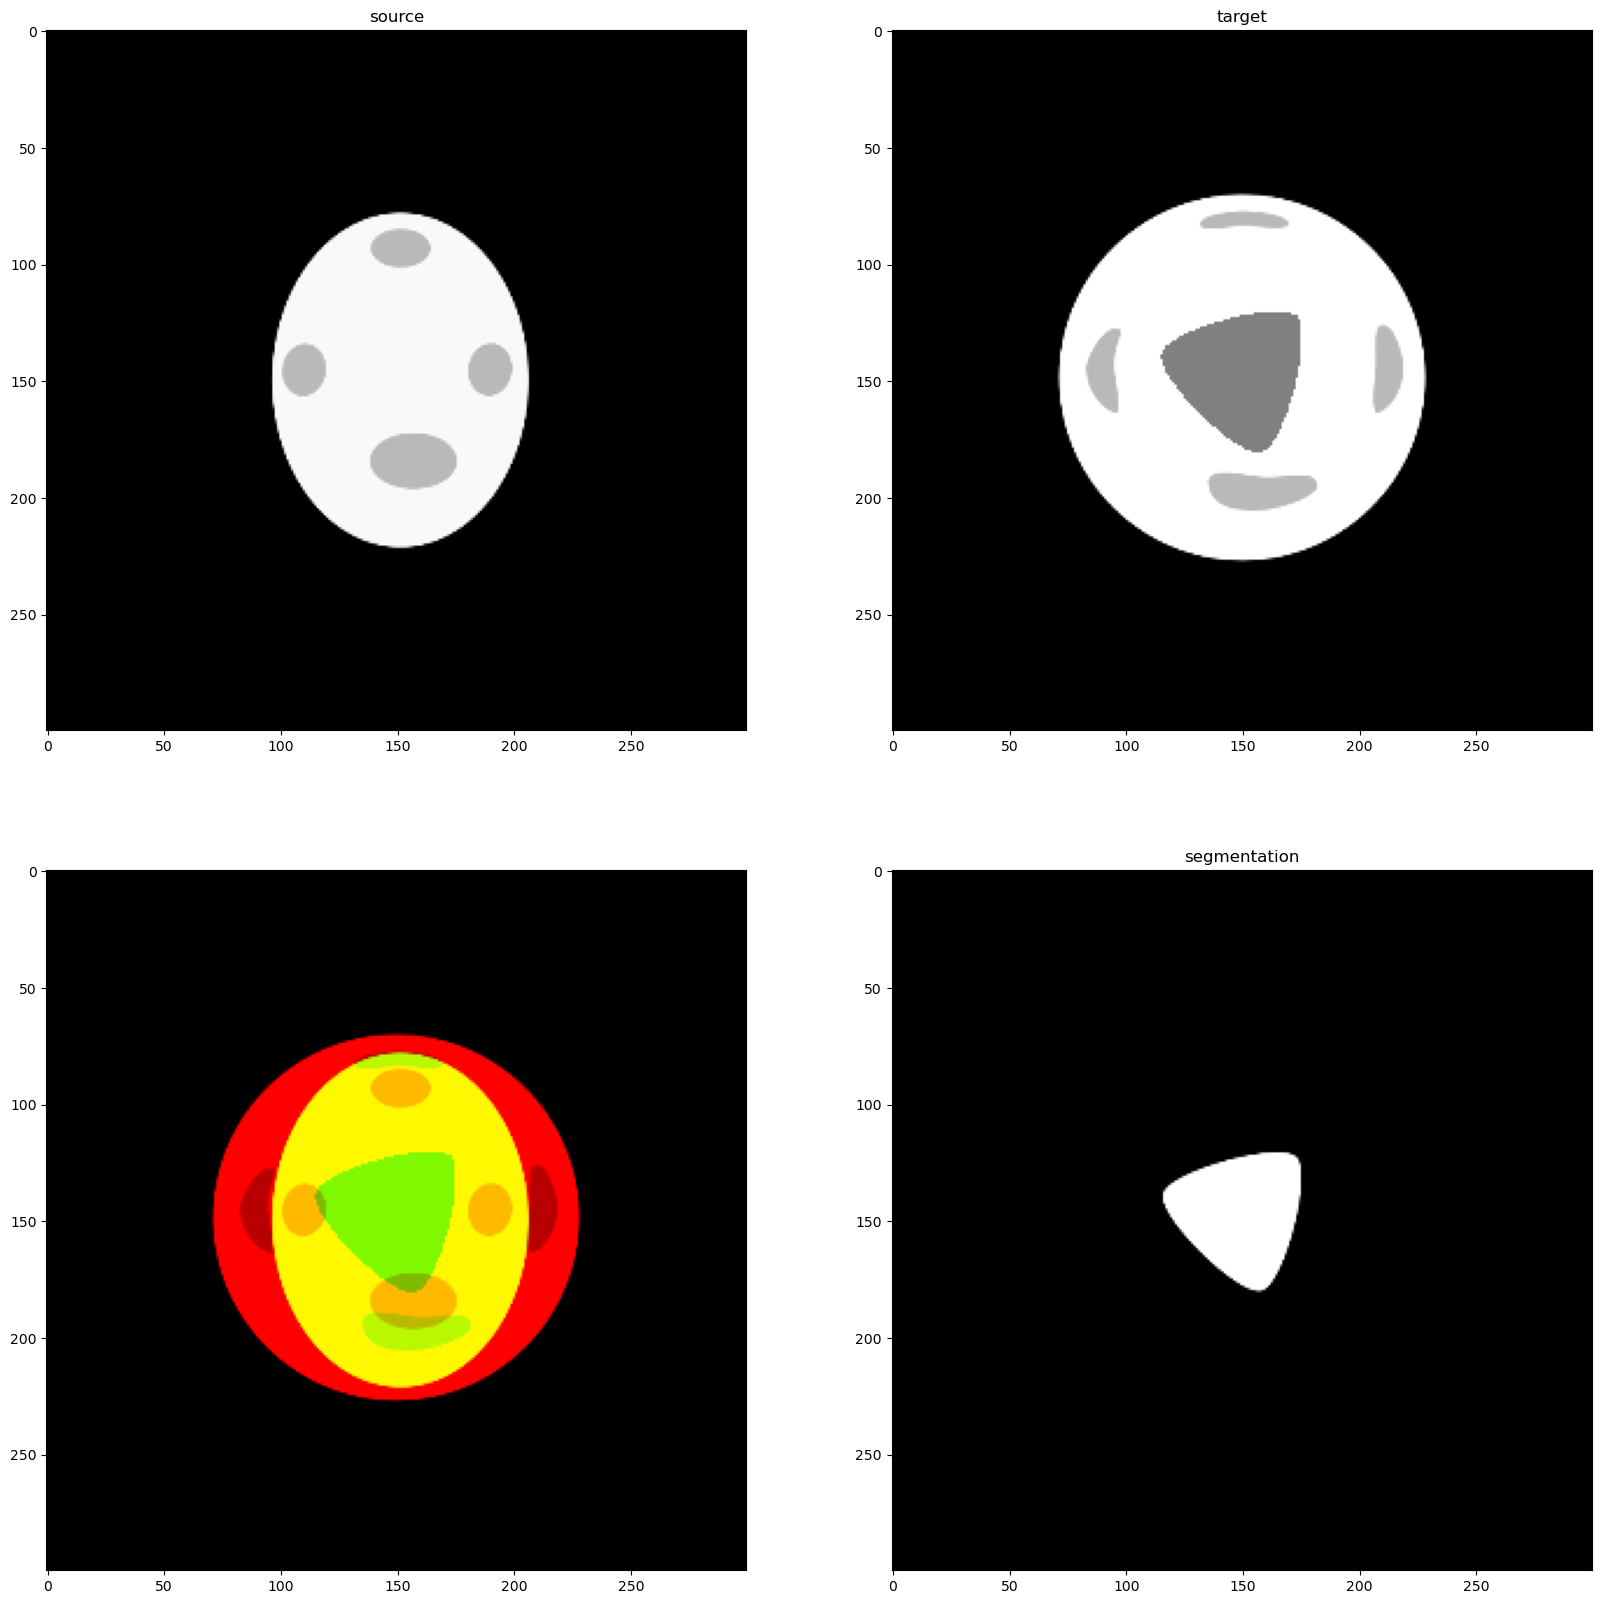

In [86]:
import __init__
import os, sys, time
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,10)
import torch
import kornia.filters as flt

from  demeter.utils.toolbox import update_progress,format_time
import demeter.utils.reproducing_kernels as rk
import gc
%load_ext autoreload
%autoreload 2
import demeter.metamorphosis as mt
import demeter.utils.torchbox as tb


gc.collect()
cuda = torch.cuda.is_available()
device = 'cpu'
if cuda:
    device = 'cuda:0'
torch.autograd.set_detect_anomaly(False)
print('device used :',device)

# Construction of the toyExample
# Lets load some images
size = (300,300)
source_name,target_name = '23','24'
S = tb.reg_open(source_name,size = size).to(device)   # Small oval with gray dots
T = tb.reg_open(target_name,size = size).to(device)   # Big circle with deformed gray dots
seg = tb.reg_open('21_seg',size=size).to(device)      # rounded triangle

# smooth the images
if False:
    sig = 1
    S = flt.gaussian_blur2d(S,(3,3),(sig,sig))
    T = flt.gaussian_blur2d(T,(3,3),(sig,sig))



#construct the target
if False:
    S = tb.addGrid2im(S,30,method='lines')
    T = tb.addGrid2im(T,30,method='lines')


print('T :',T.max(),' S :',S.max())
## Construct the target image
ini_ball,_ = tb.make_ball_at_shape_center(seg,overlap_threshold=.1,verbose=True)
ini_ball = ini_ball.to(device)
T[seg>0] = 0.5                                       # Add the rounded triangle to the target

source = S
target = T
# mask = mr.mp.image_stock

source_name = 'oval_w_round'
target_name = 'round_w_triangle_p_rd'

kw_img = dict(cmap='gray',vmin=0,vmax=1)
plt.rcParams["figure.figsize"] = (20,20)
fig,ax = plt.subplots(2,2)
ax[0,0].imshow(source[0,0,:,:].cpu().numpy(),**kw_img)
ax[0,0].set_title('source')
ax[0,1].imshow(target[0,0,:,:].cpu().numpy(),**kw_img)
ax[0,1].set_title('target')
ax[1,0].imshow(tb.imCmp(source,target),vmin=0,vmax=1)
ax[1,1].imshow(seg[0,0].cpu().numpy(),**kw_img)
ax[1,1].set_title('segmentation')
plt.show()

# 0./ How to read the plots
For each Experiments successives plots are showed :
 1. __Cost evolution__
    1. With relative coefficients, (i.e.: we plot $\rho \|z_0\|_{L^2}^2$)
    2. Raw values (i.e.: we plot $\|z_0\|_{L_2}^2$)
 2. __Visualisation of the method end product__. We compare the image at the end of the geodesic ($I_1$) with source and target images
 3. __Geodesic evolution visualisation__. Each row represent a given time point, The first collumn is the image evolution ($I_t$), the second show the residuals ($z_t$) and the third the deformation generated by the field $v_t$.
 4. __Deformation visualisation.__ In this series of plot we show the quality of the end deformation $\Phi = \int_0^1 v_t dt; v_0 = Id$
     1. Deformation grid of $\Phi$
     2. Quiver plot of $\Phi$
     3. (4 images) Comparison of the image deformed by $\Phi$ with the source and target images.


# 1./ Classical methods : LDDMM and Metamorphosis

Before demonstrating the Weighted Metamorphosis results, lets show how LDDMM and the classical Methamorphosis behave on this toy examples.

## 1.a. LDDMM

We solve the cost:
$$H(z_0) =   \frac 12\| I_{1} - T \|_{L_2}^2 + \lambda  \|v_0\|^2_V $$
with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right>
\end{array}
\right.
$$

In [87]:
import demeter.metamorphosis.data_cost as dt
sigma= [(5,5),(30,30)]
# sigma = (30,30)
# sigma = get_sigma_from_img_ratio(source.shape,30)
# sigma = tuple([ sig /float(max(source.shape)) for sig in sigma])
print("sigma",sigma)
cost_cst = .1
integration_step,n_iter,grad_coef = (5,15,1)
residuals = 0
# kernelOp = rk.GaussianRKHS(sigma)
kernelOp = rk.Multi_scale_GaussianRKHS(sigma)
# kernelOp.plot()
# data_cost = dt.Ssd_normalized(target)
data_cost = None
start = time.time()
mr_lddmm = mt.lddmm(source,target,residuals,kernelOp,cost_cst,
                    integration_step,n_iter,grad_coef,
                    data_term=data_cost,
                    safe_mode=False,
                    dx_convention='pixel',
                    optimizer_method='LBFGS_torch'
                   )
end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr_lddmm.plot()

sigma [(5, 5), (30, 30)]
sigma :  (5, 5)
sigma :  (30, 30)
Progress: [##########] 100.00% Done...  ,356.2934).
 (ssd :  ,355.7046).
Computation of forward done in  0:00:10s and 0.596cents  s

Computation of lddmm done in  0:00:10s and 0.597cents  s

Computation done in  0:00:10s and 0.597cents  s


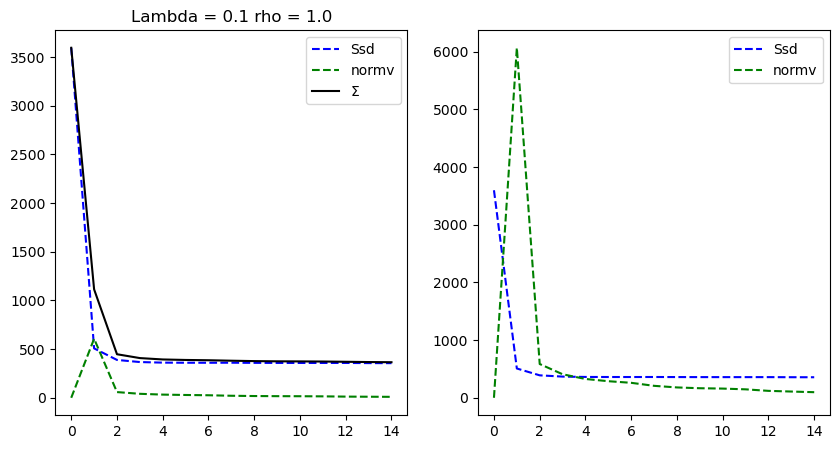

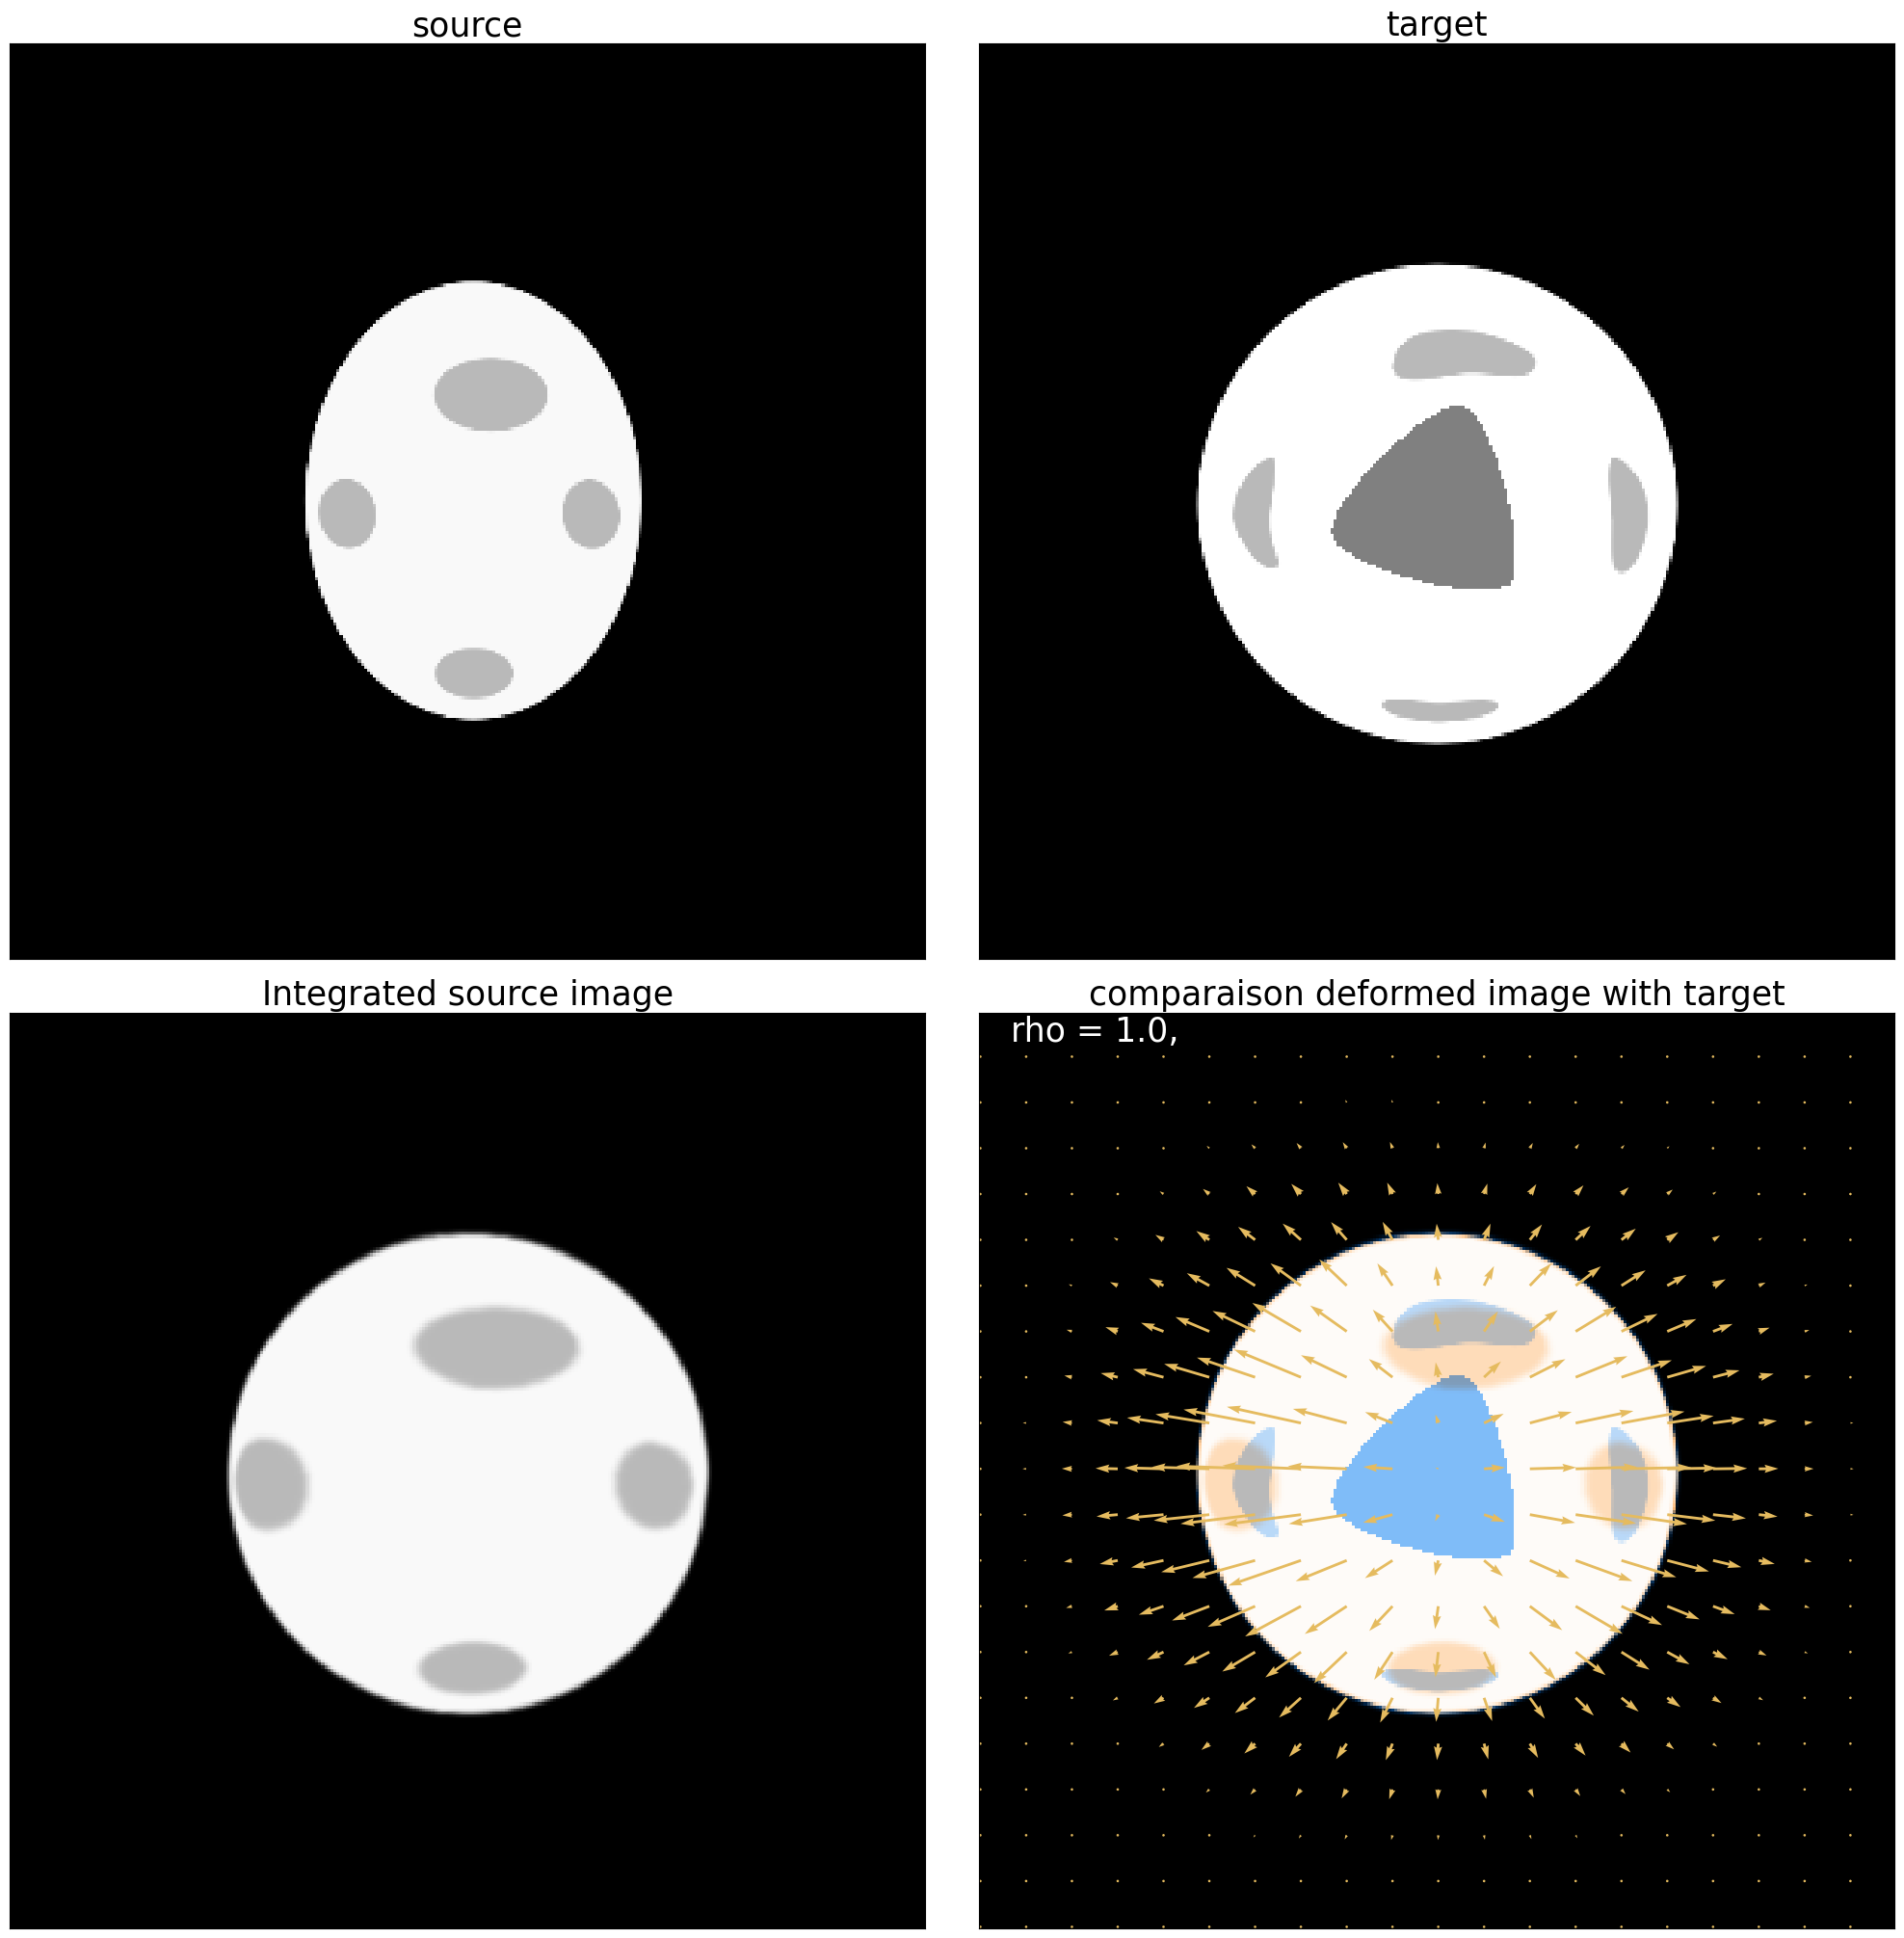

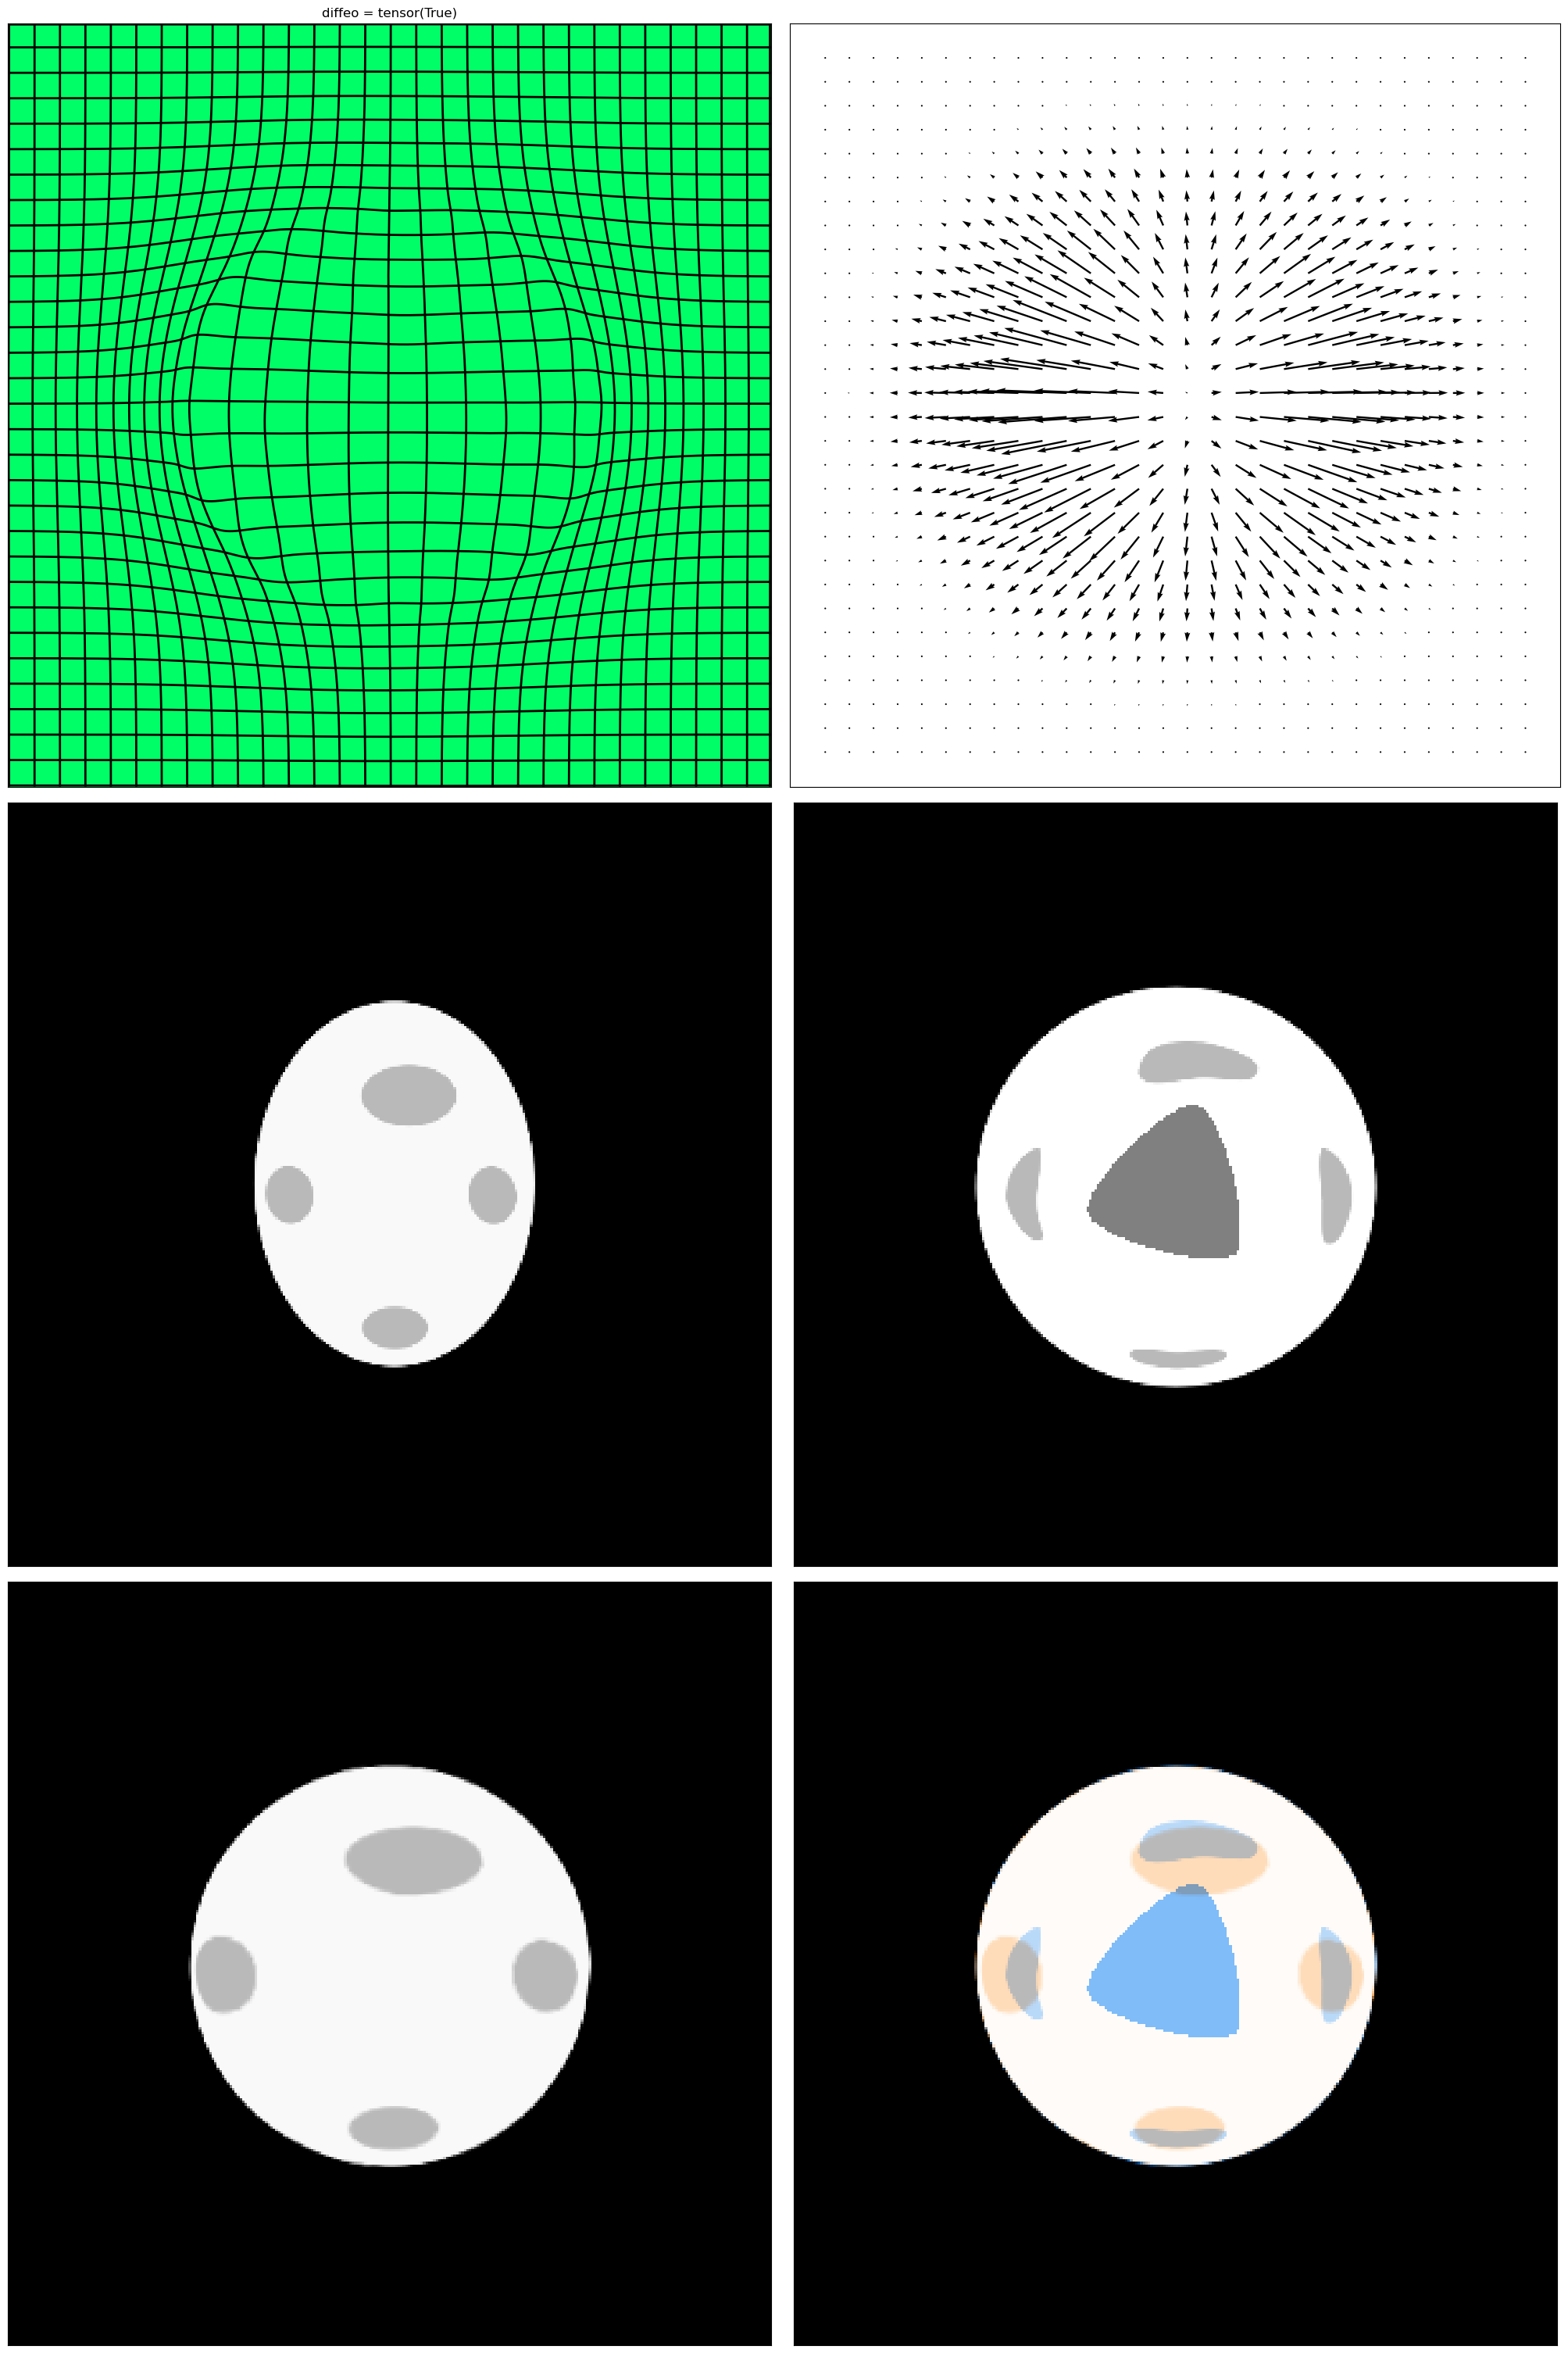

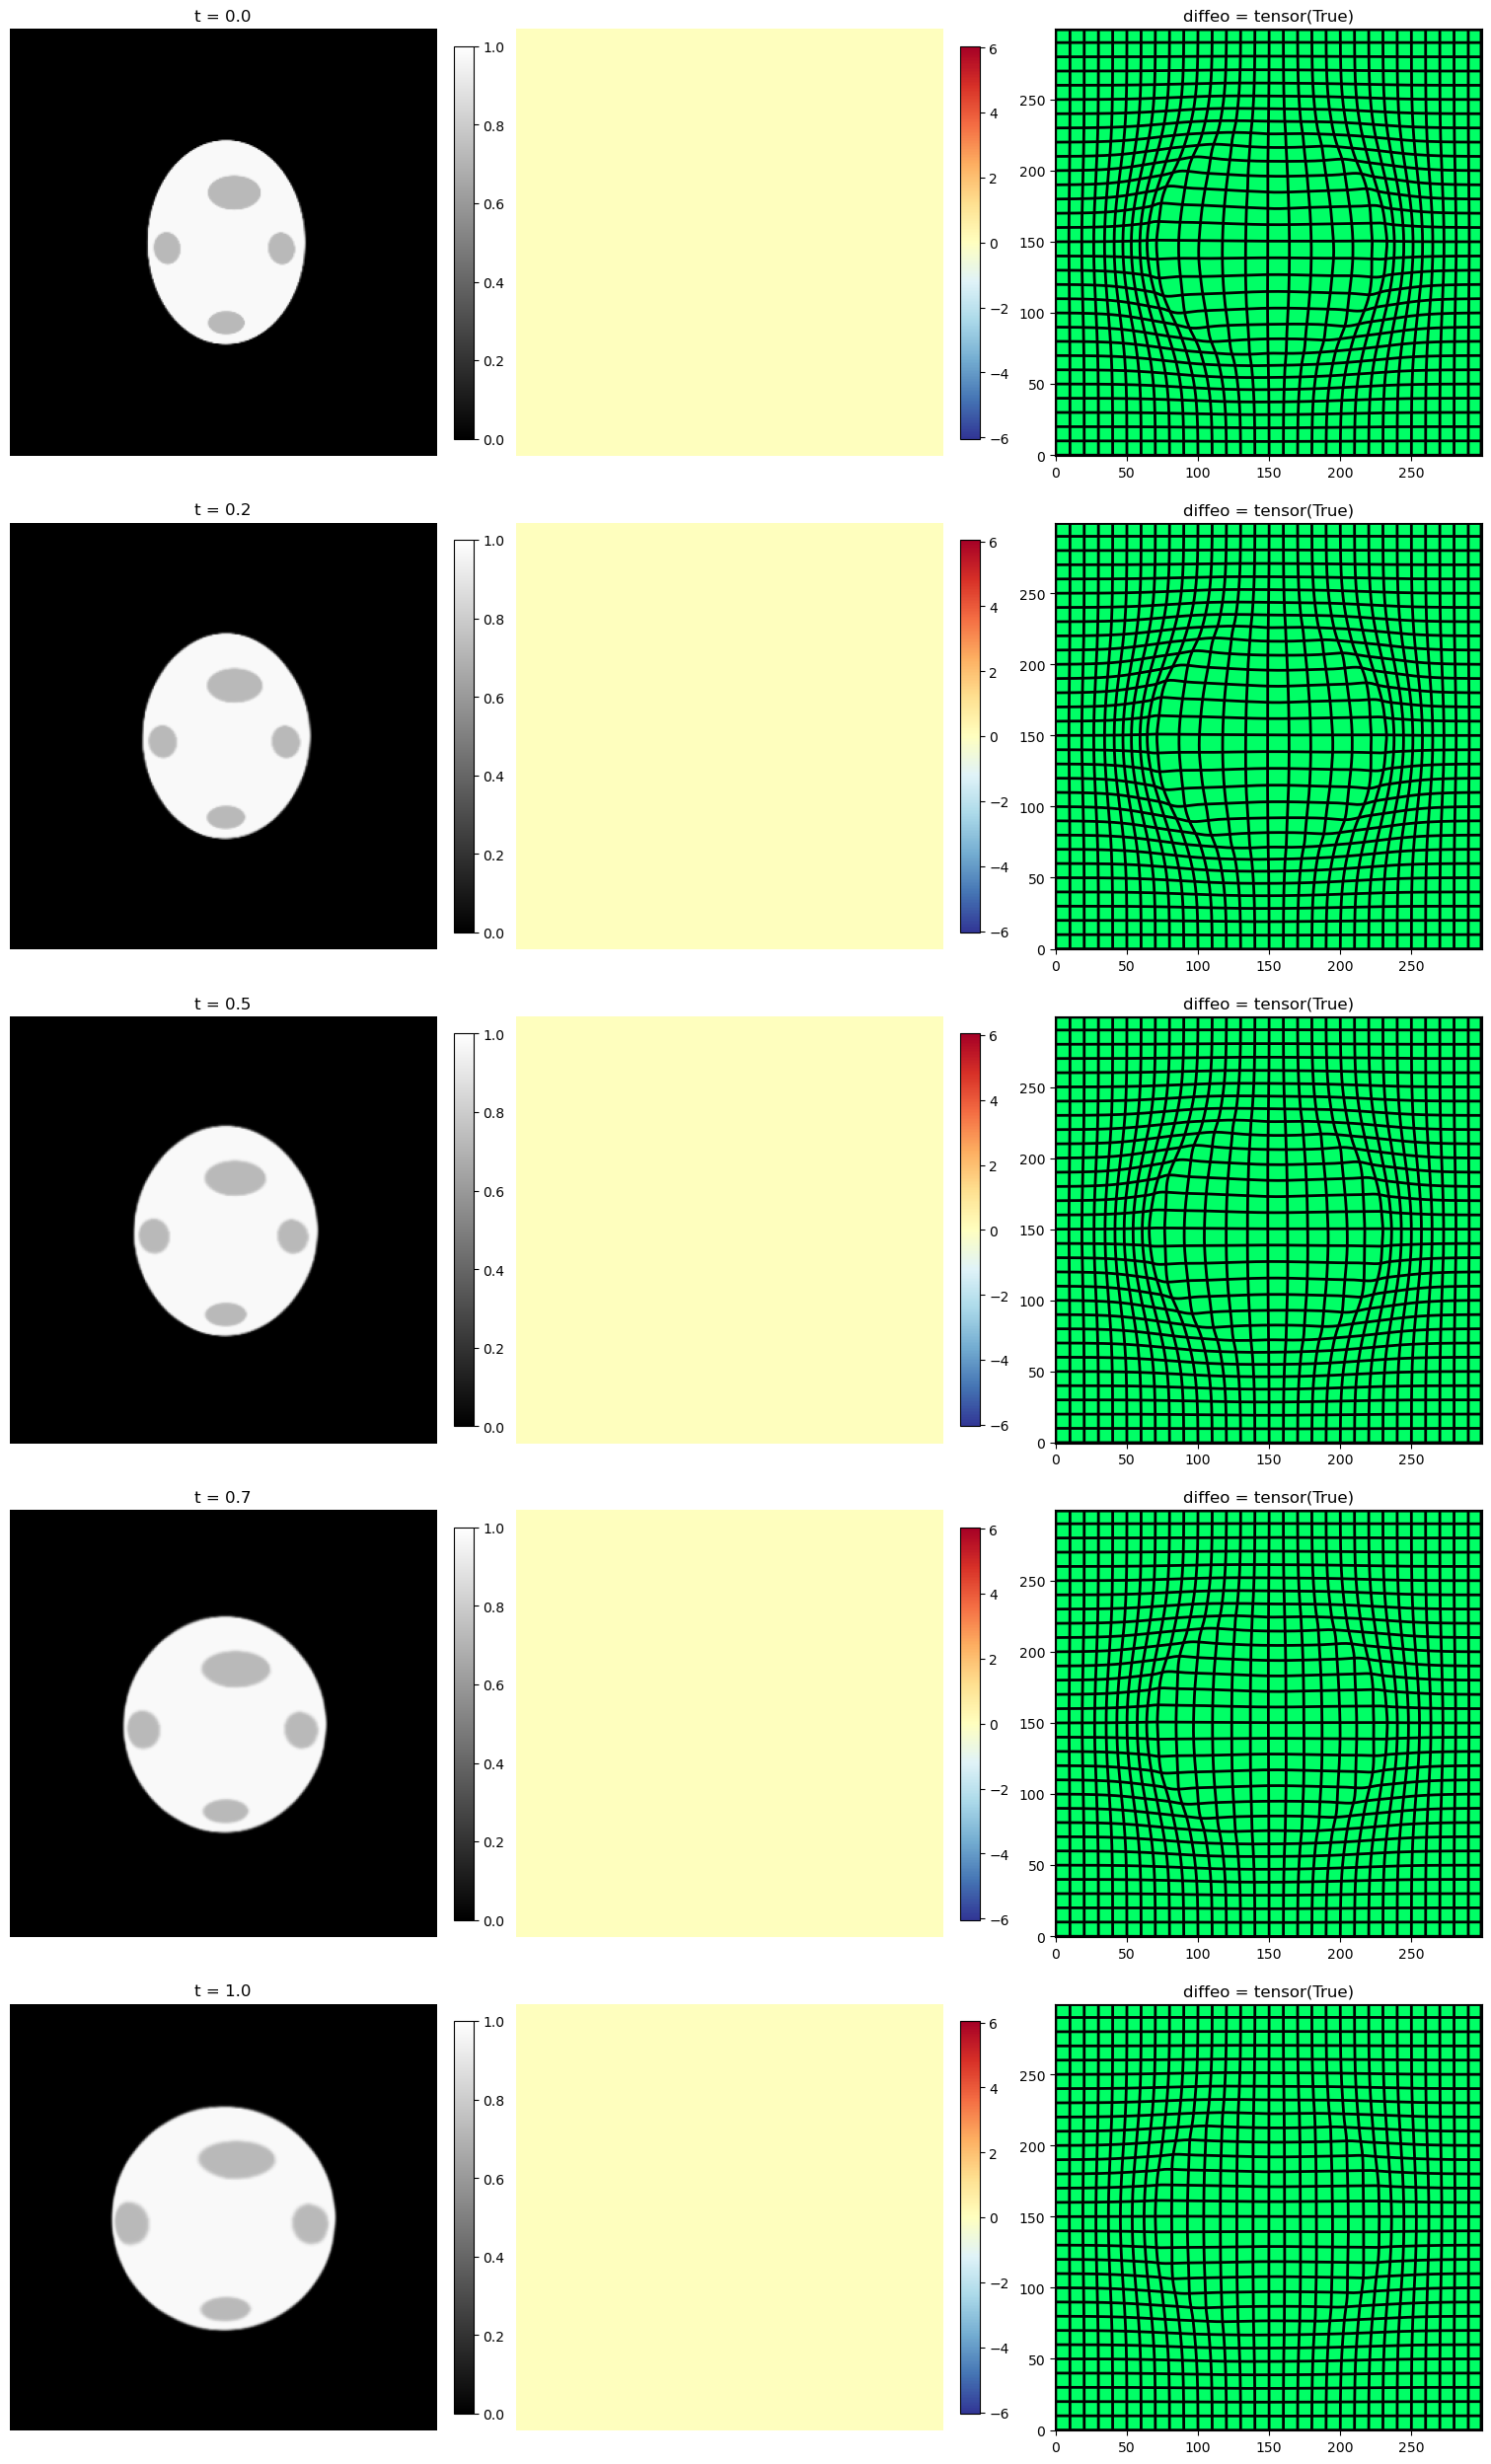

In [88]:
mr_lddmm.plot_deform()
mr_lddmm.mp.plot()
plt.show()

Annimation :
<img src="gifs/playExample_LDDMM.gif" width="500" align="center">

## 1.b Metamorphosis

We solve the cost:
$$H(z_0) =   \frac 12\| I_1 - T \|_{L_2}^2 + \lambda \Big[ \|v_0\|^2_V + \rho \|z_0\|^2_{L_2} \Big]$$

with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - \frac{\rho}{\mu} K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right> + \mu z_t
\end{array}
\right.
$$


In [89]:
sigma = rk.get_sigma_from_img_ratio(source.shape,30)
# sigma = tuple([ sig /float(max(source.shape)) for sig in sigma])
print("sigma",sigma)

# mu = 300 # only photometric differences
rho,lamb = (0.9,.0001)
integration_step,n_iter,grad_coef = (10,15,1)

residuals = 0
# residuals = mr_meta.to_analyse[0].clone().to(device)
mr_meta = mt.metamorphosis(source,target,residuals,rho,lamb,
                    integration_step,n_iter,grad_coef,
                    kernelOp,
                    data_term=None,
                    safe_mode=False,
                    dx_convention='pixel',
                    optimizer_method='LBFGS_torch',
                    # optimizer_method='adadelta',                           
)

print(f"image min/max : {mr_meta.mp.image.min(),mr_meta.mp.image.max()}")
mr_meta.plot(y_log=False)

sigma (10.729830131446736, 10.729830131446736)
Progress: [##########] 100.00% Done...  , 33.0063).
 (ssd :  , 31.1992).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47793132066726685..1.7409380674362183].



Computation of forward done in  0:00:16s and 0.005cents  s

Computation of metamorphosis done in  0:00:16s and 0.006cents  s
image min/max : (tensor(-0.4779), tensor(1.7409))


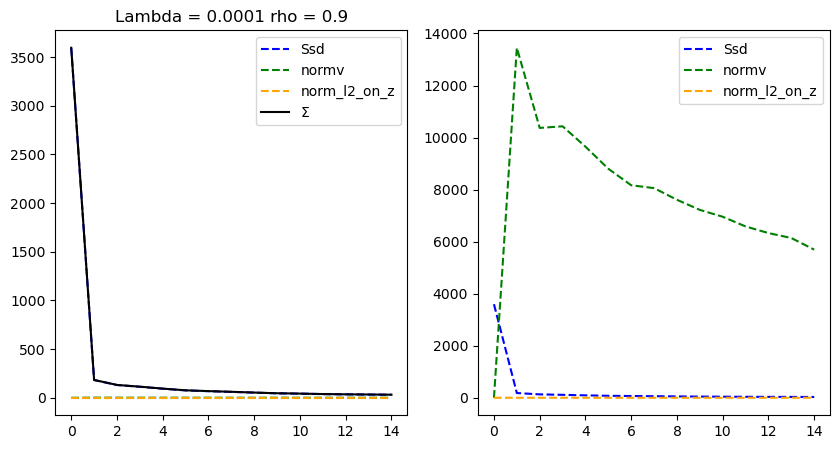

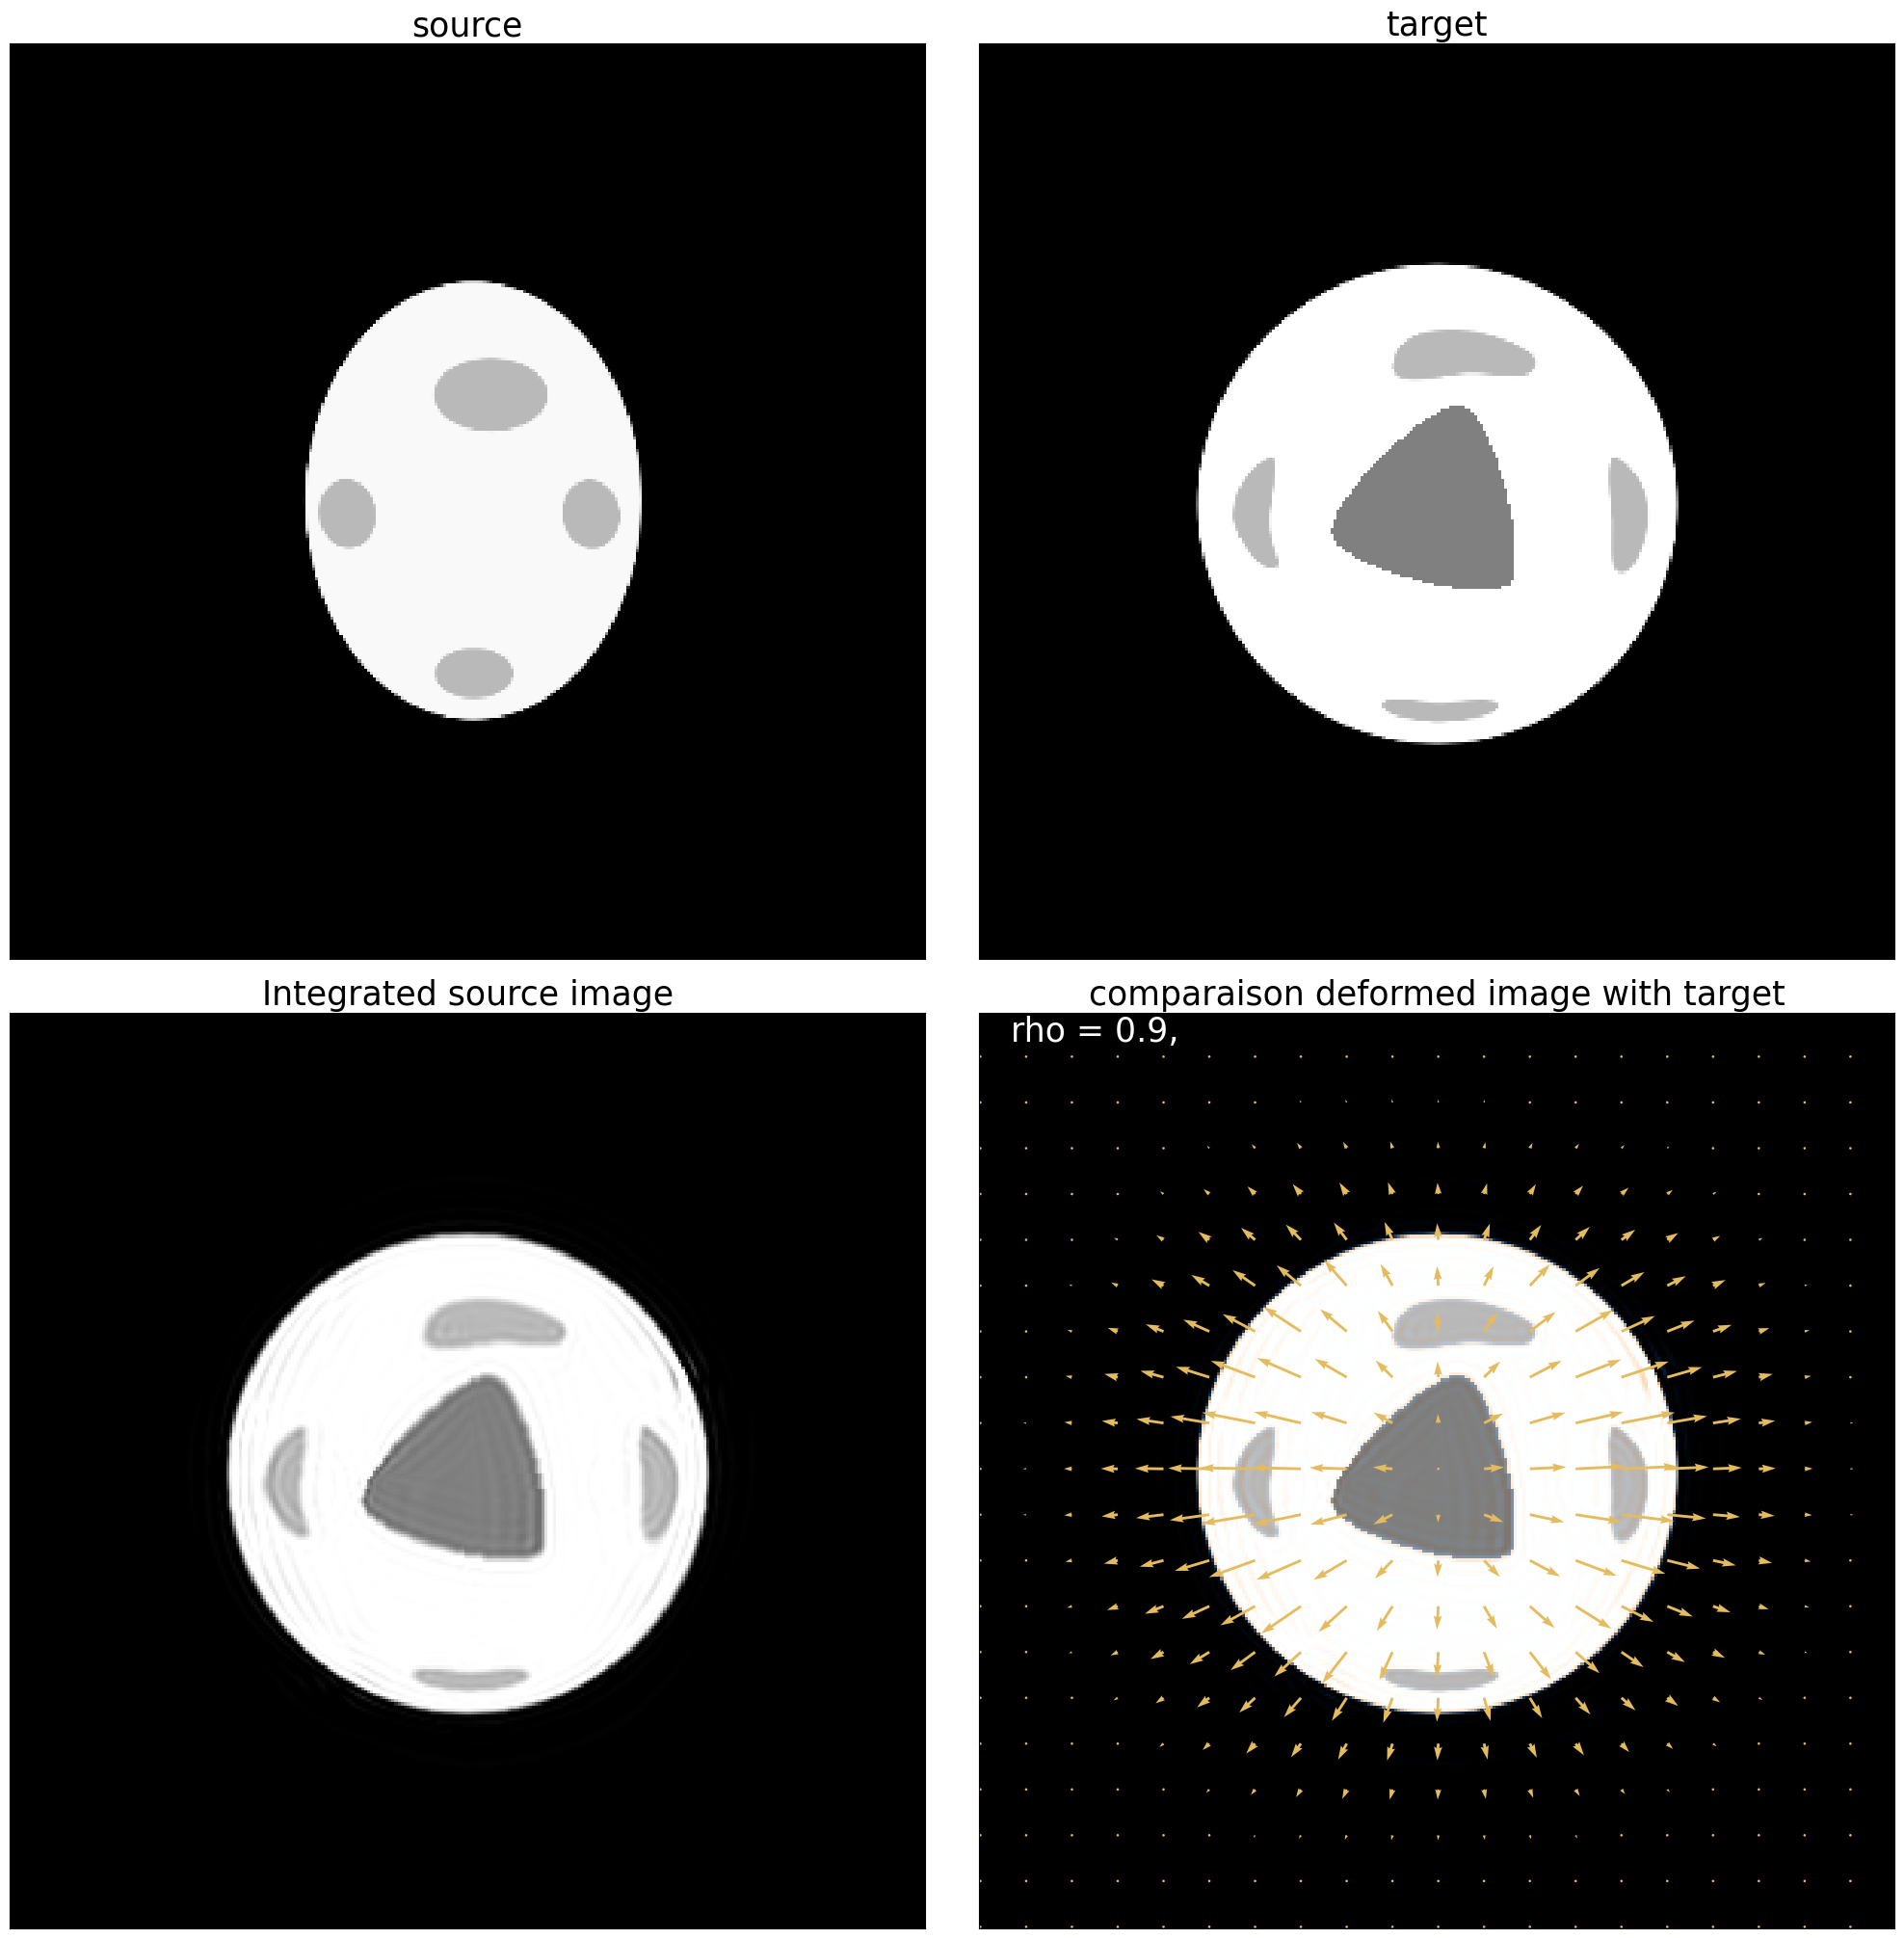

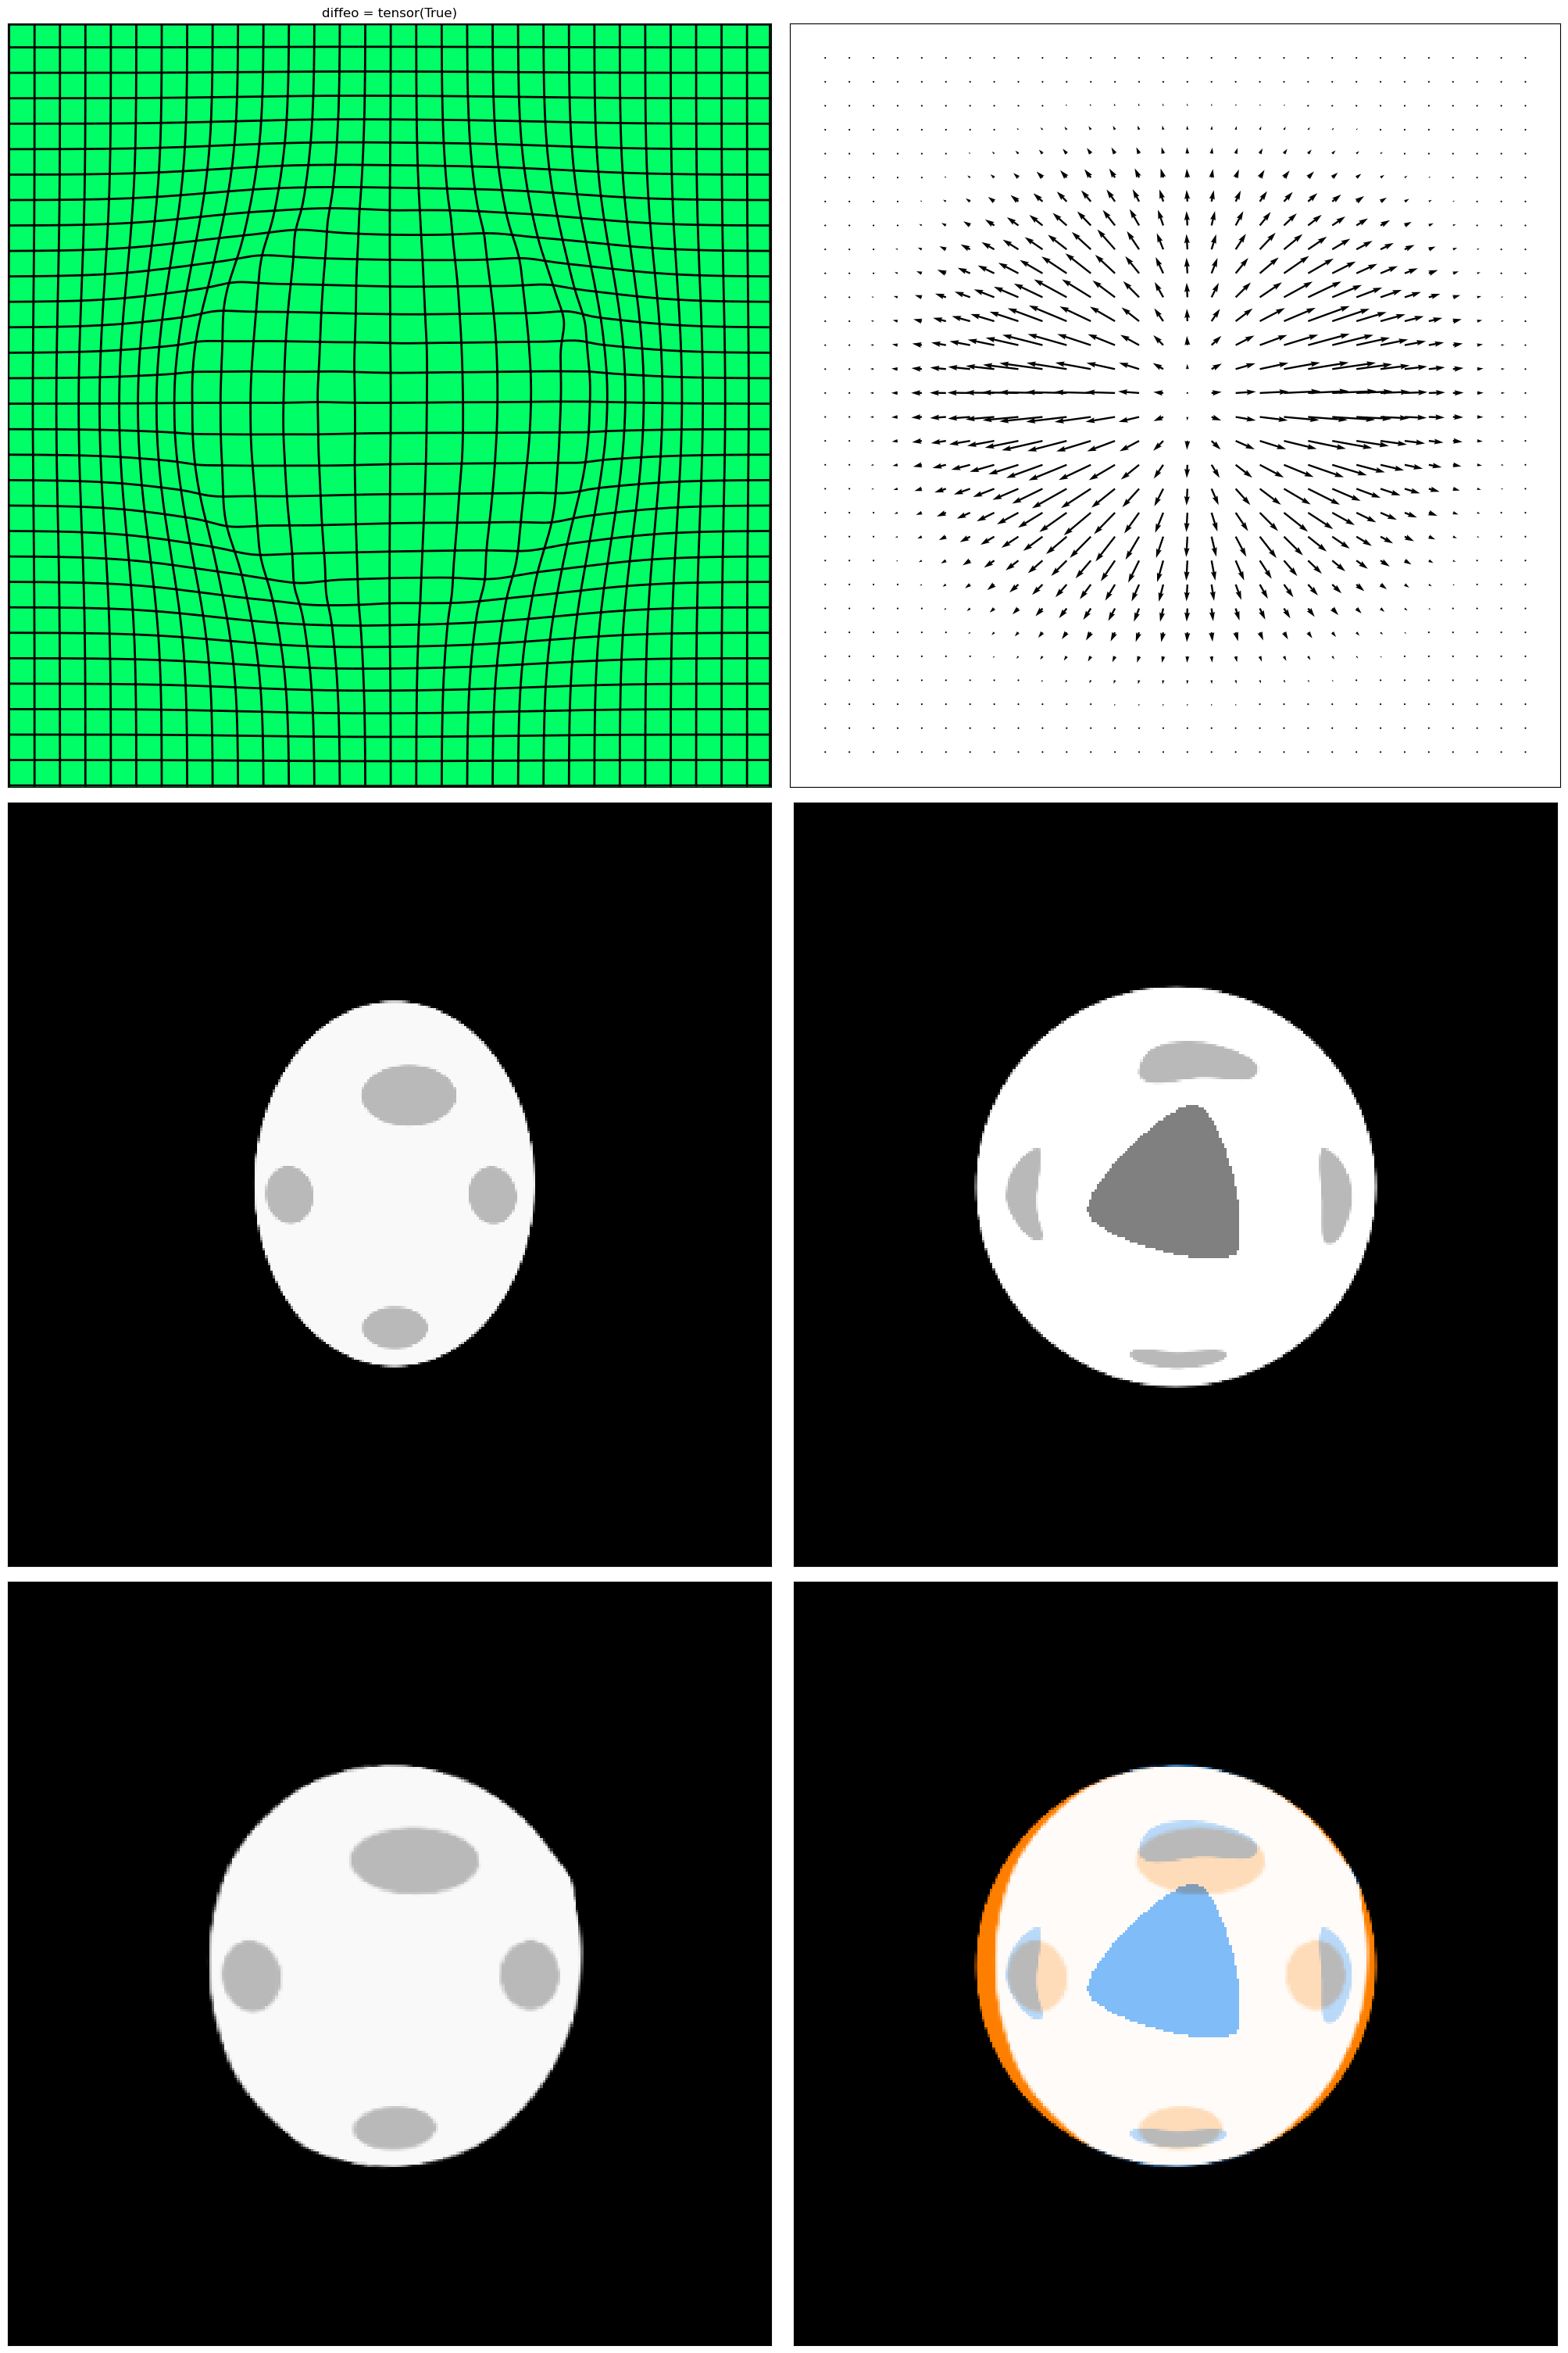

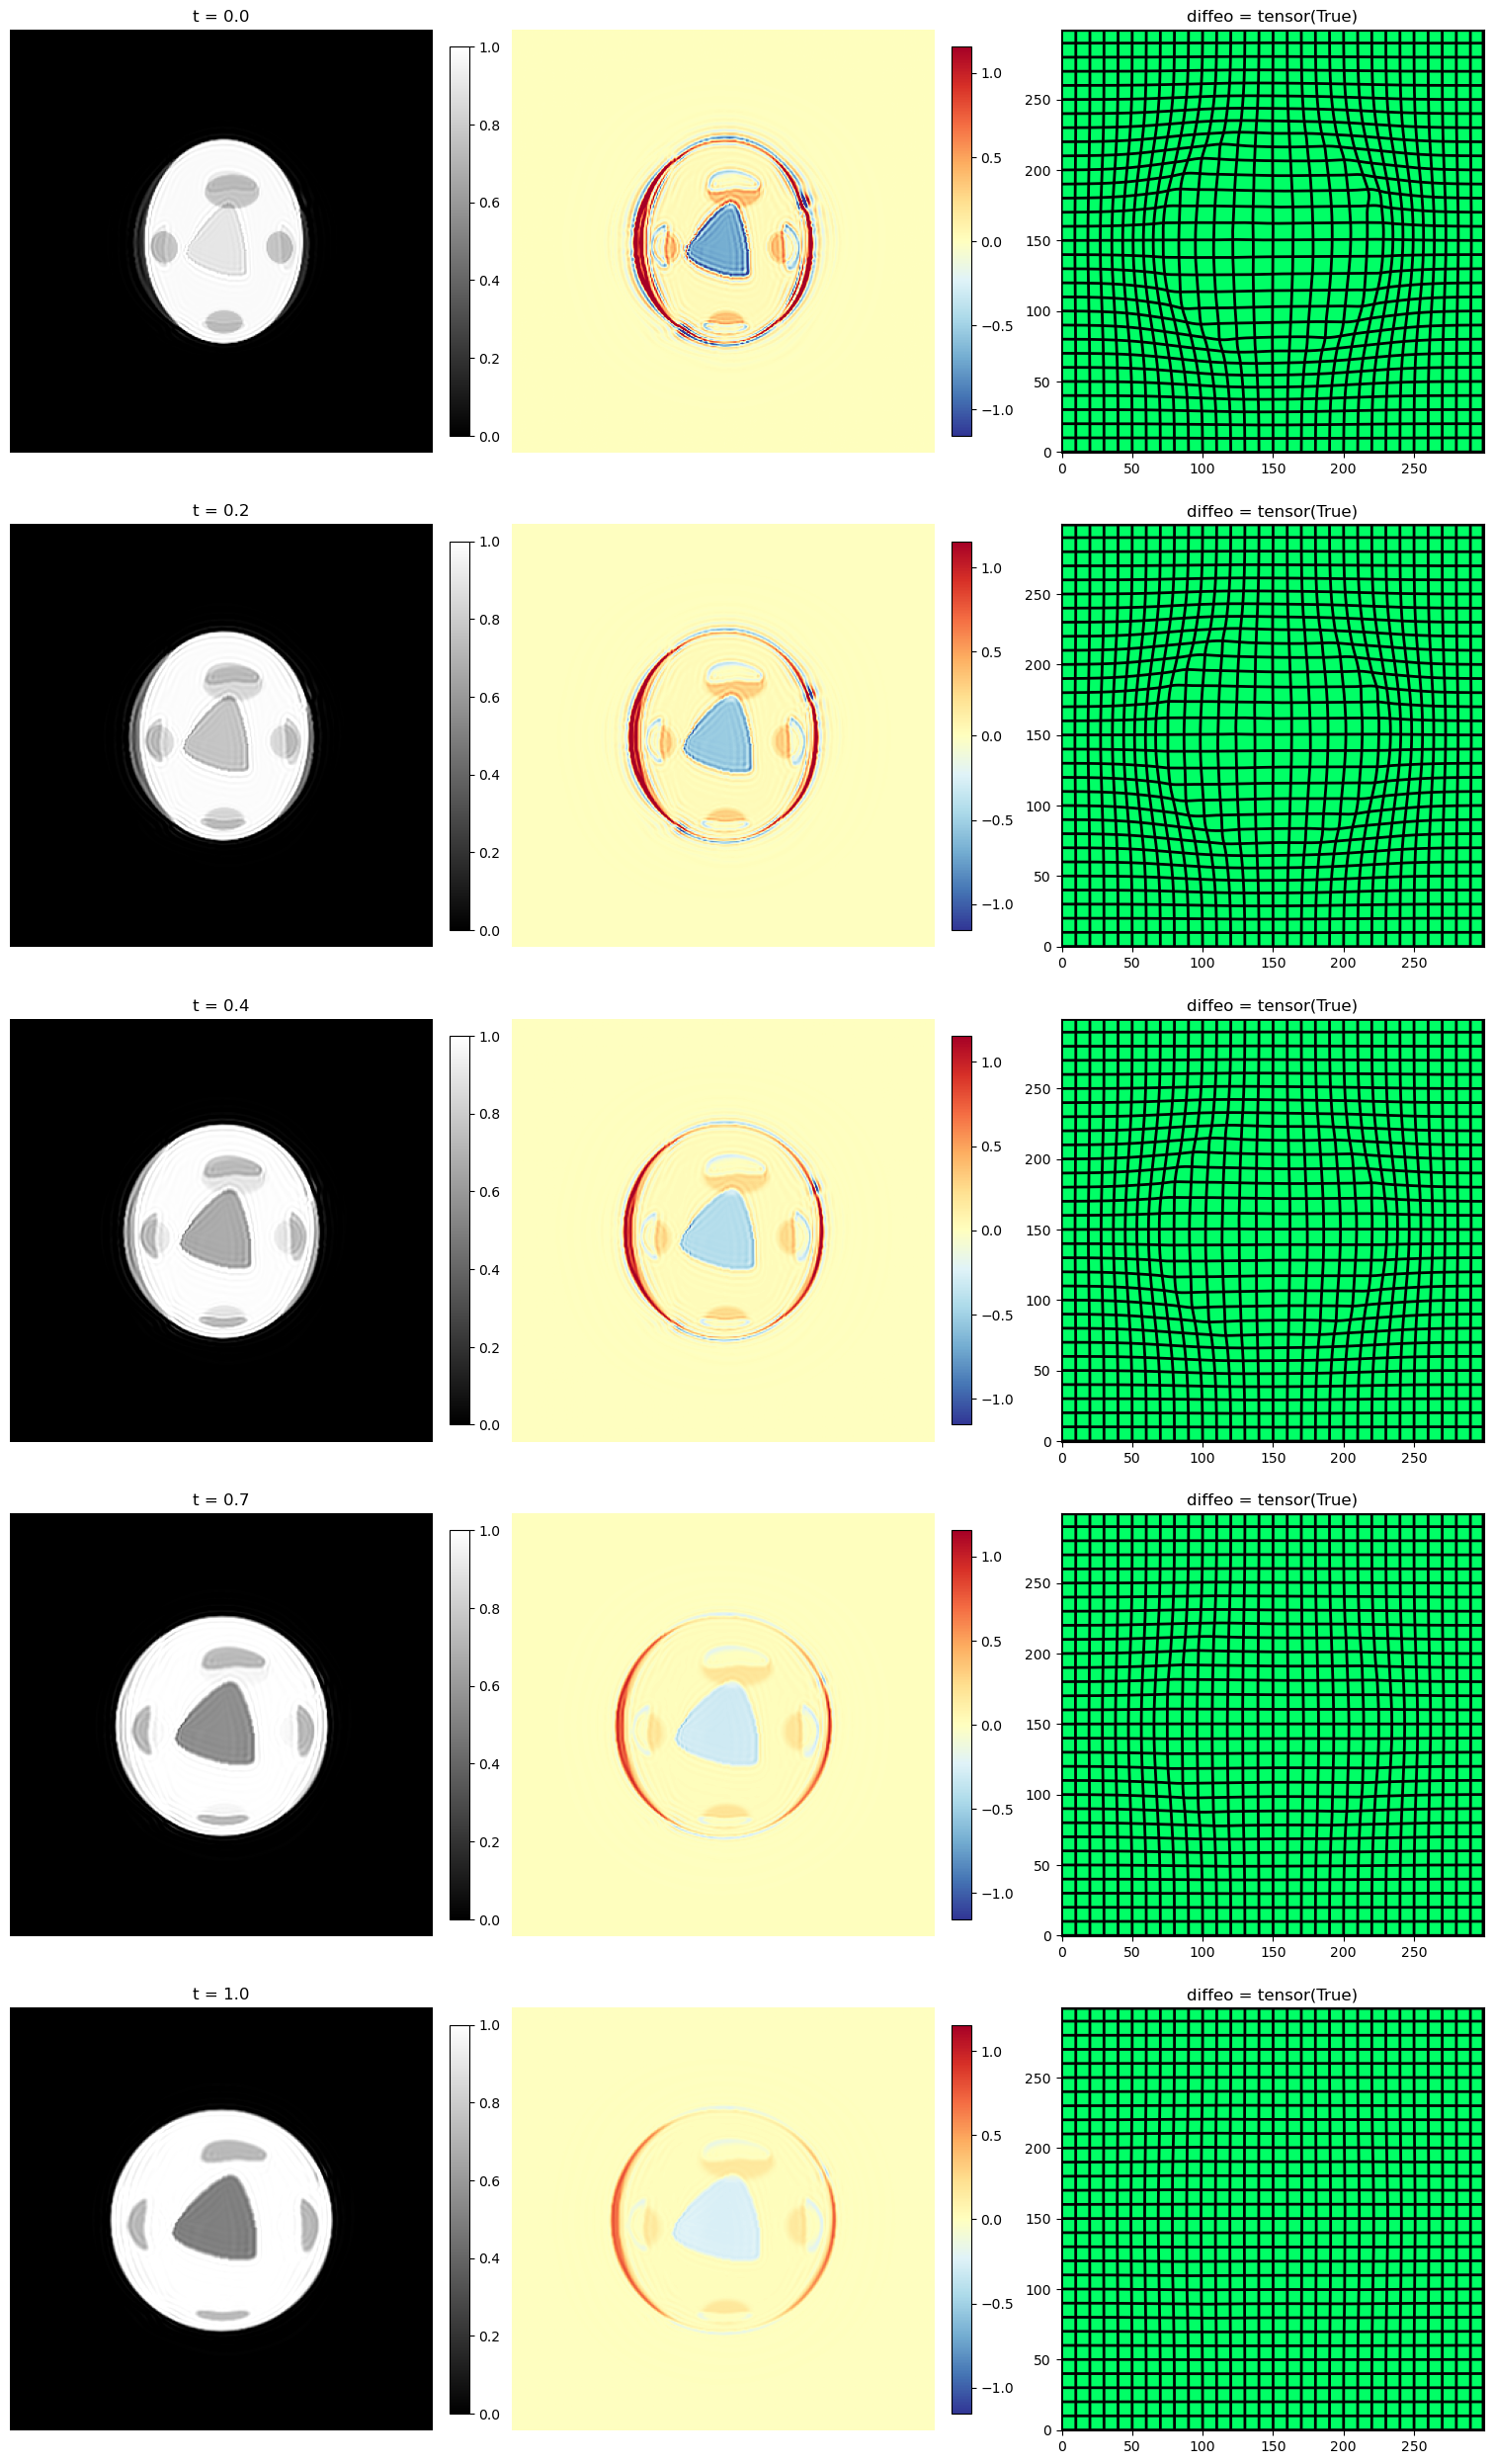

In [90]:
mr_meta.plot_deform()
mr_meta.mp.plot()
plt.show()

Annimation :
<img src="gifs/playExample_Meta.gif" width="500" align="center">




# 2./ Weighted Metamorphoses.



## 2.a./ Weighted Metamorphosis with constant mask

In this sub-section we set $\forall t \in [0,1], M_t = M_1$ where $M_1$ is the segmentation mask.

We solve the cost:
$$H(z_0) =   \frac 12\| I_1 - T \|_{L_2}^2 + \lambda \Big[ \|v_0\|^2_V + \rho \|\sqrt{M_0}z_0\|^2_{L_2} \Big]$$

with $I_1$ begin integrated from the geodesic system :
$$
\left\{
\begin{array}{rl}
    v_t &= - \frac{\rho}{\mu} K \star  (z_t \nabla I_t)\\
    \dot  z_t &= -\quad \nabla \cdot (z_t v_t)  \\
    \dot I_t &= - \left< \nabla I_t,v_t\right> + \mu z_t
\end{array}
\right.
$$


In [91]:
# sigma = get_sigma_from_img_ratio(source.shape,[[30,30],[40,40]])
# sigma = tuple([ sig /float(max(source.shape)) for sig in sigma])
sigma= [(1,1),(5,5),(10,10),(30,30)]
print("sigma",sigma)

# inverse the mask to have M(x) = 0 where we want to add
# intensity.
cst_mask = 1 - seg.repeat(10,1,1,1)
lamb= .0001
n_iter,grad_coef = (10,.1)
residuals = 0
start = time.time()
mr_wm = mt.weighted_metamorphosis(source,target,residuals,cst_mask,
                    kernelOperator=kernelOp,
                    cost_cst=lamb,
                    n_iter=n_iter,
                    grad_coef=grad_coef,
                    safe_mode=False,
                    dx_convention='pixel',
                    optimizer_method='LBFGS_torch'
)

end = time.time()
print("\nComputation done in ",format_time(end - start)," s")

sigma [(1, 1), (5, 5), (10, 10), (30, 30)]
plop
Weighted
not oriented
Progress: [##########] 100.00% Done...  , 89.4859).
 (ssd :  , 87.2977).
Computation of forward done in  0:00:11s and 0.304cents  s

Computation of weighted_metamorphosis done in  0:00:11s and 0.304cents  s

Computation done in  0:00:11s and 0.305cents  s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3268851041793823].


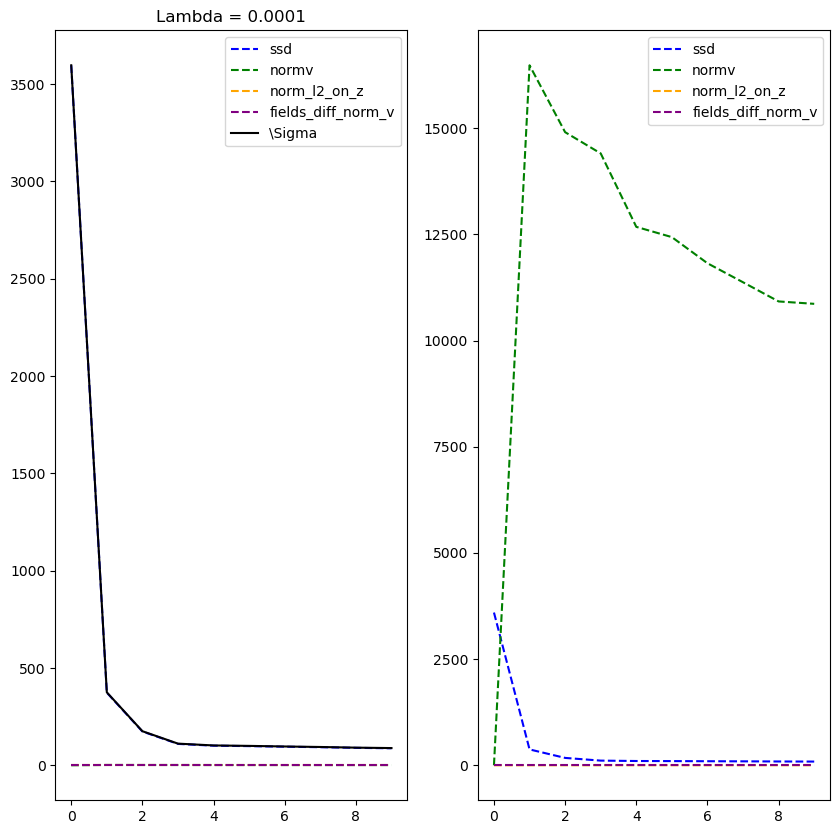

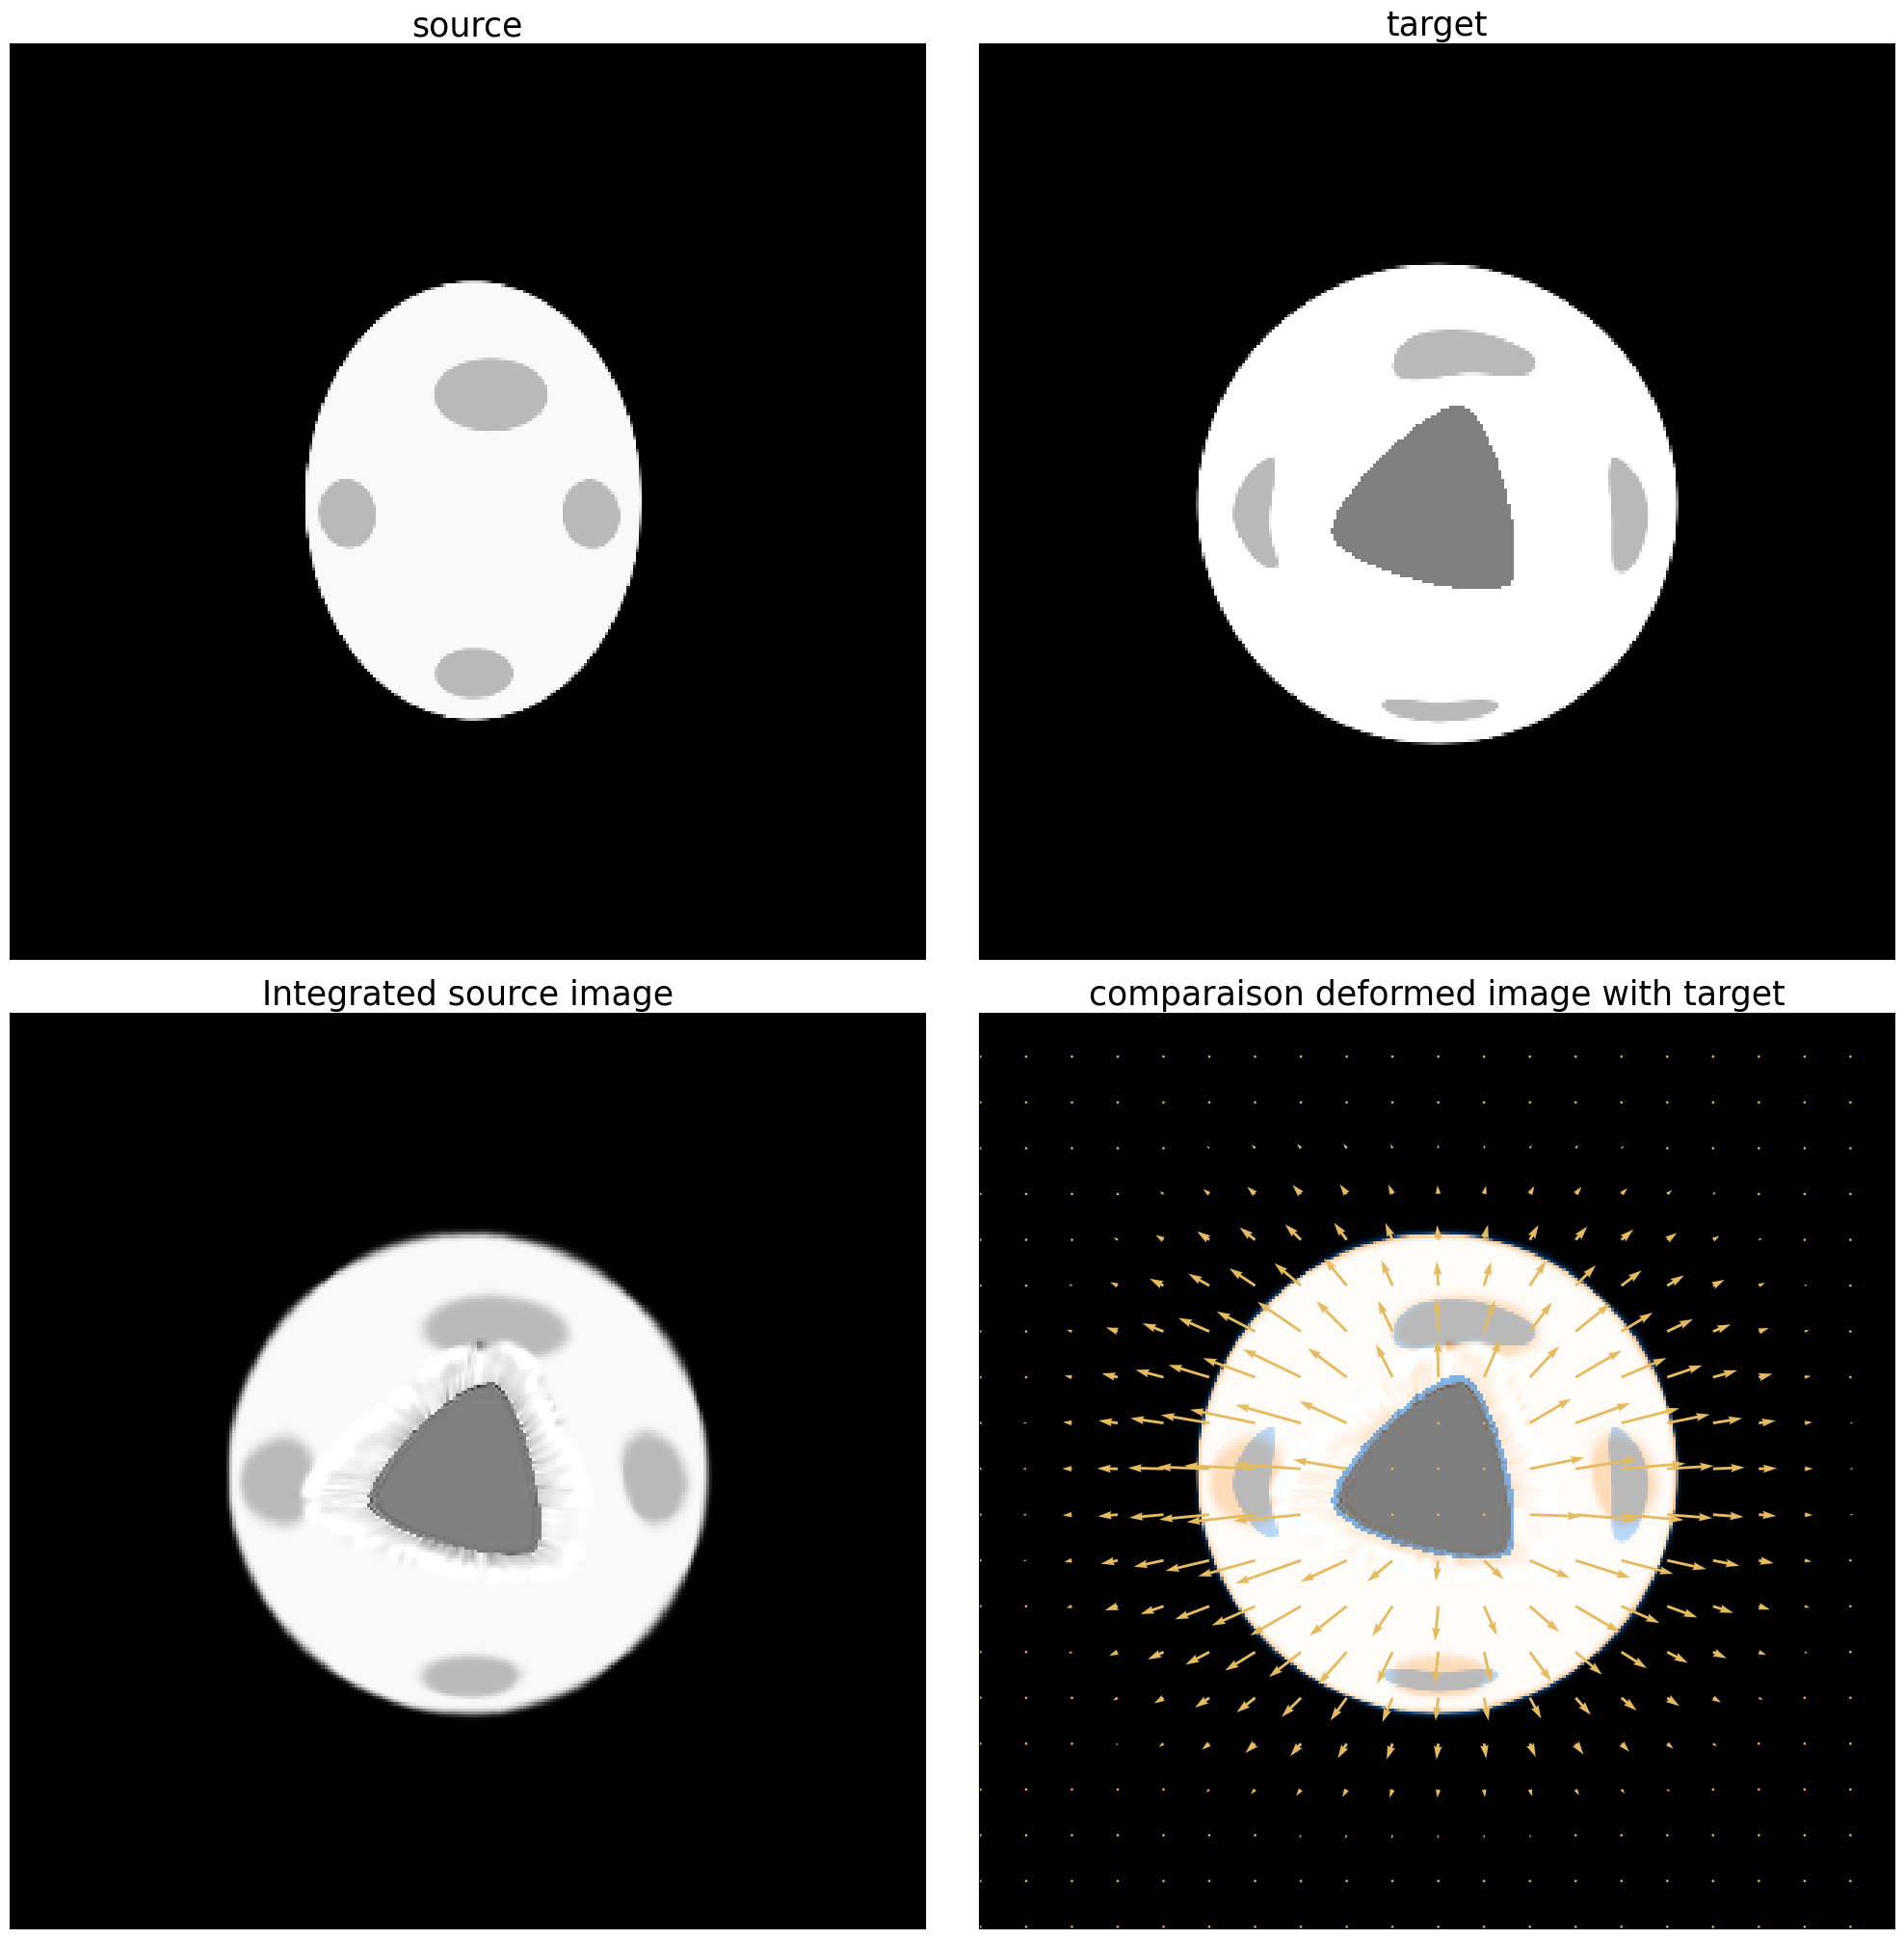

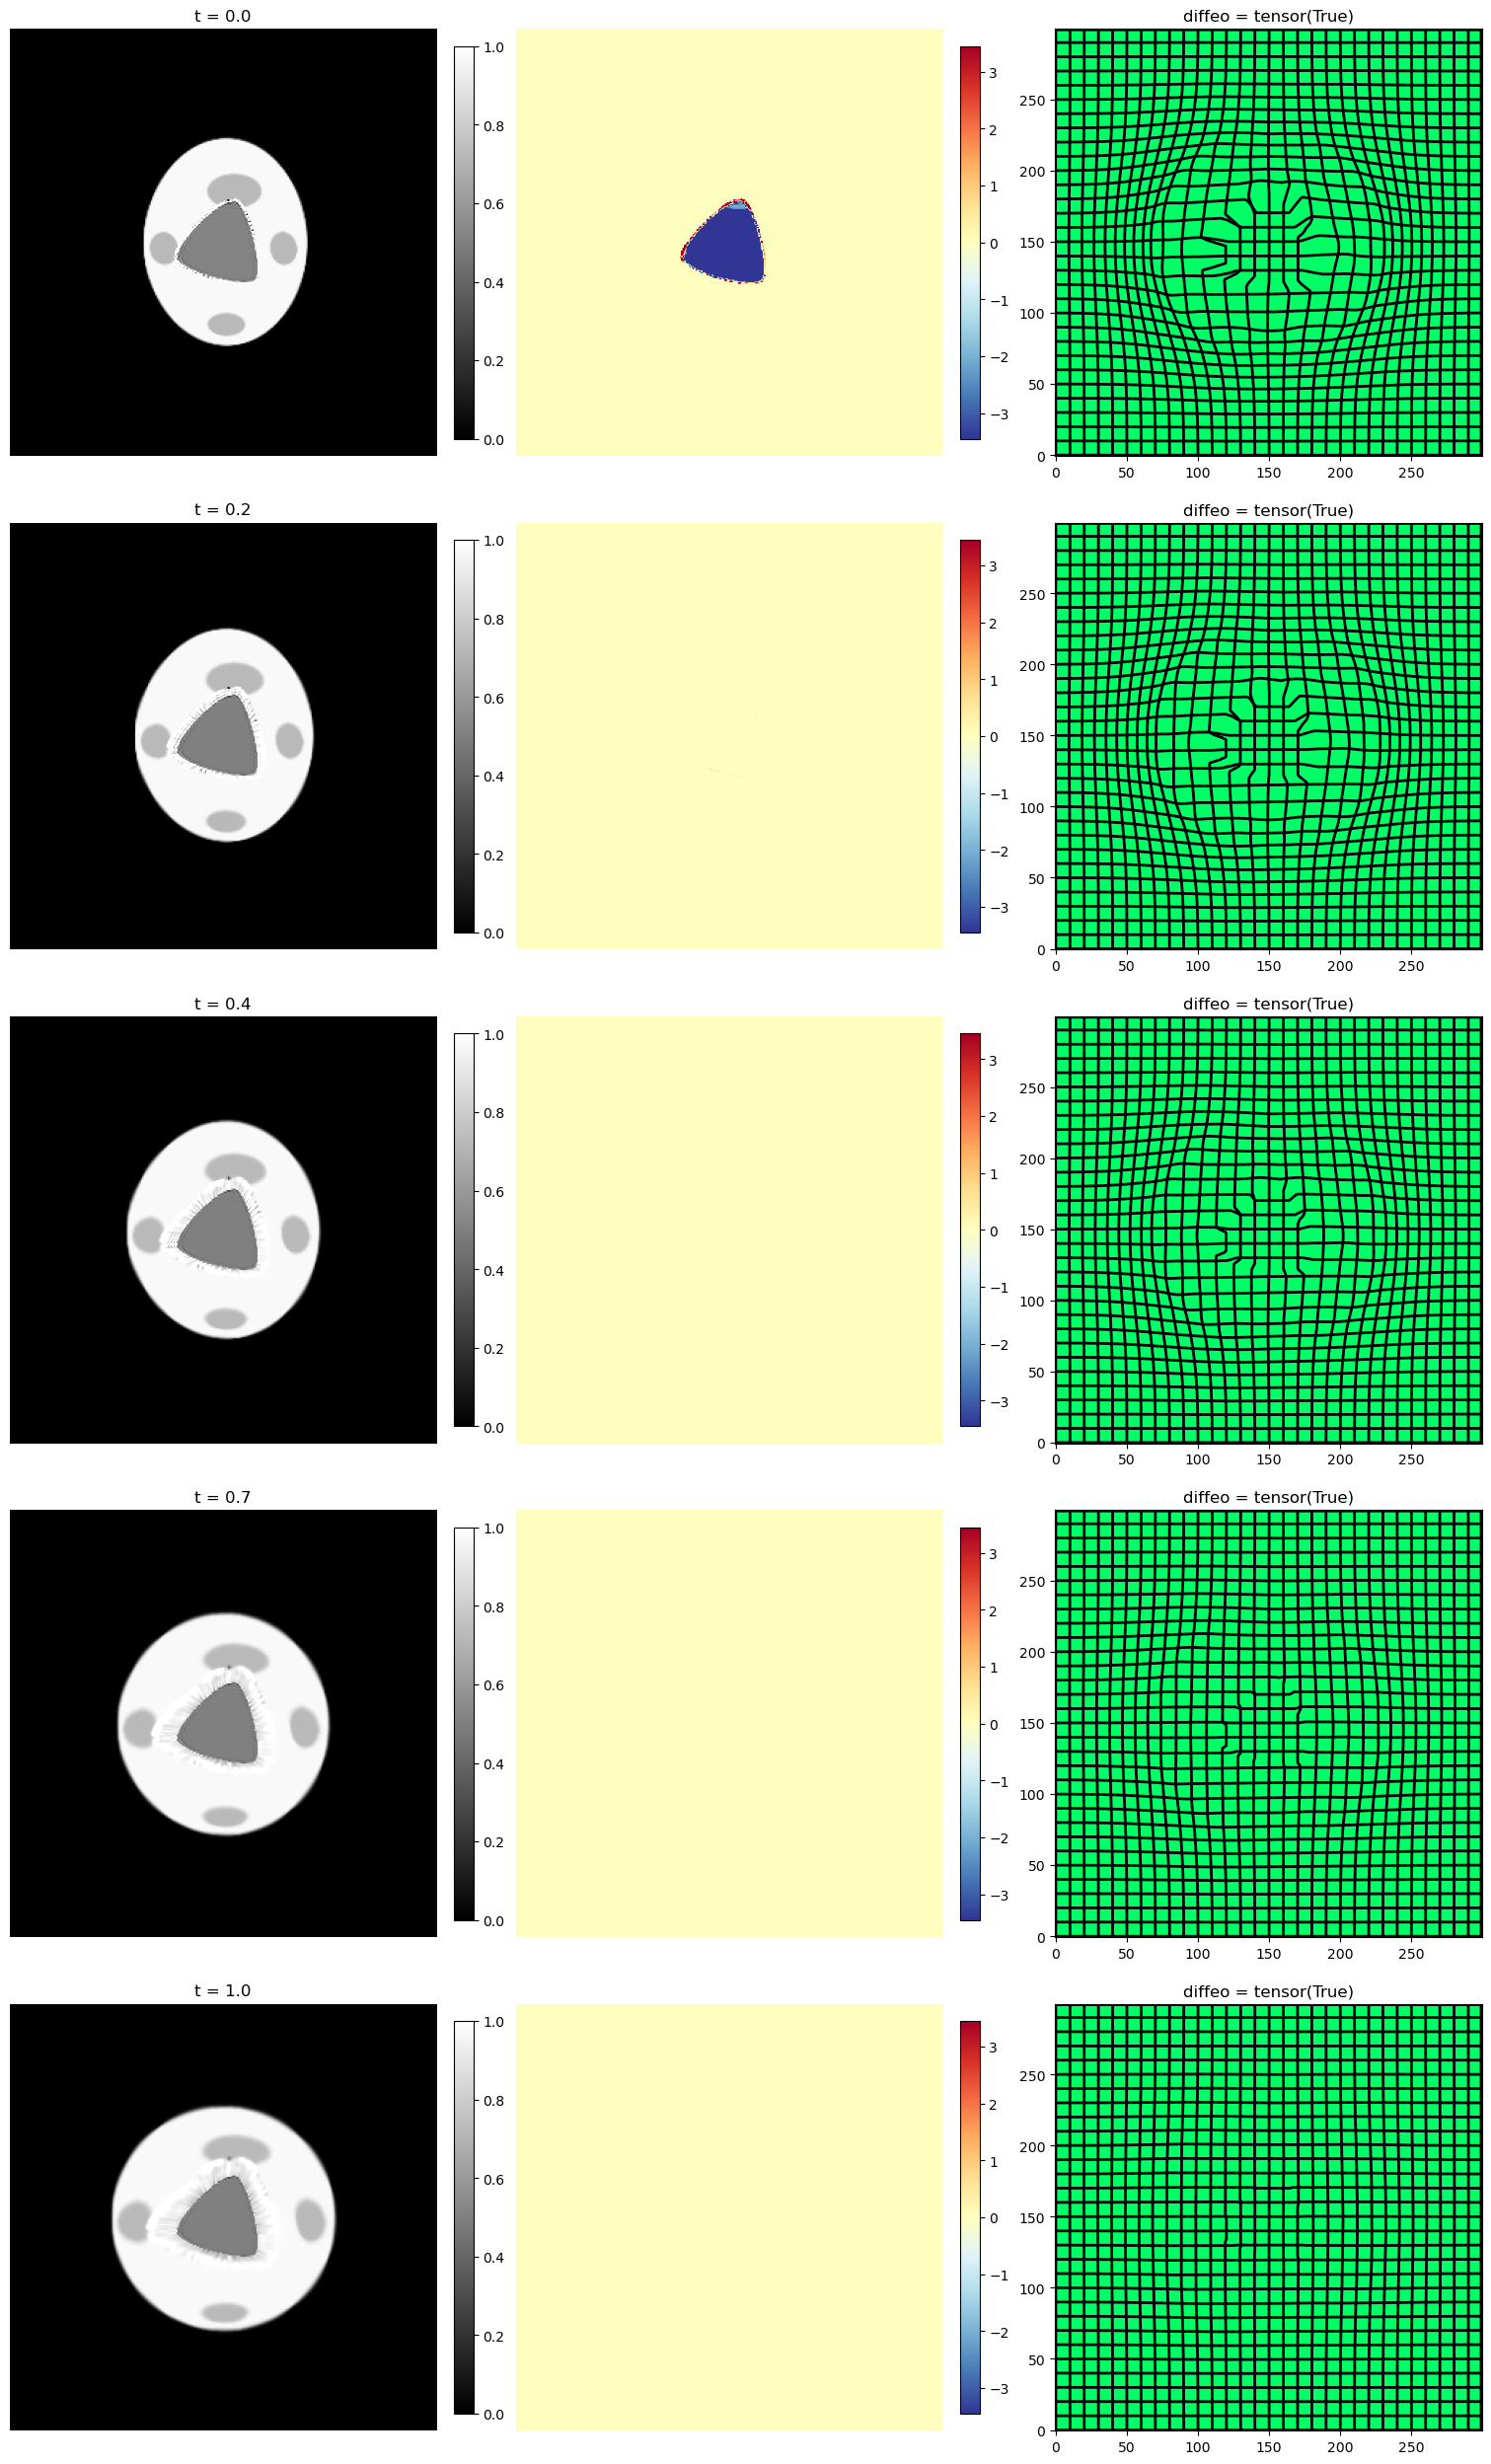

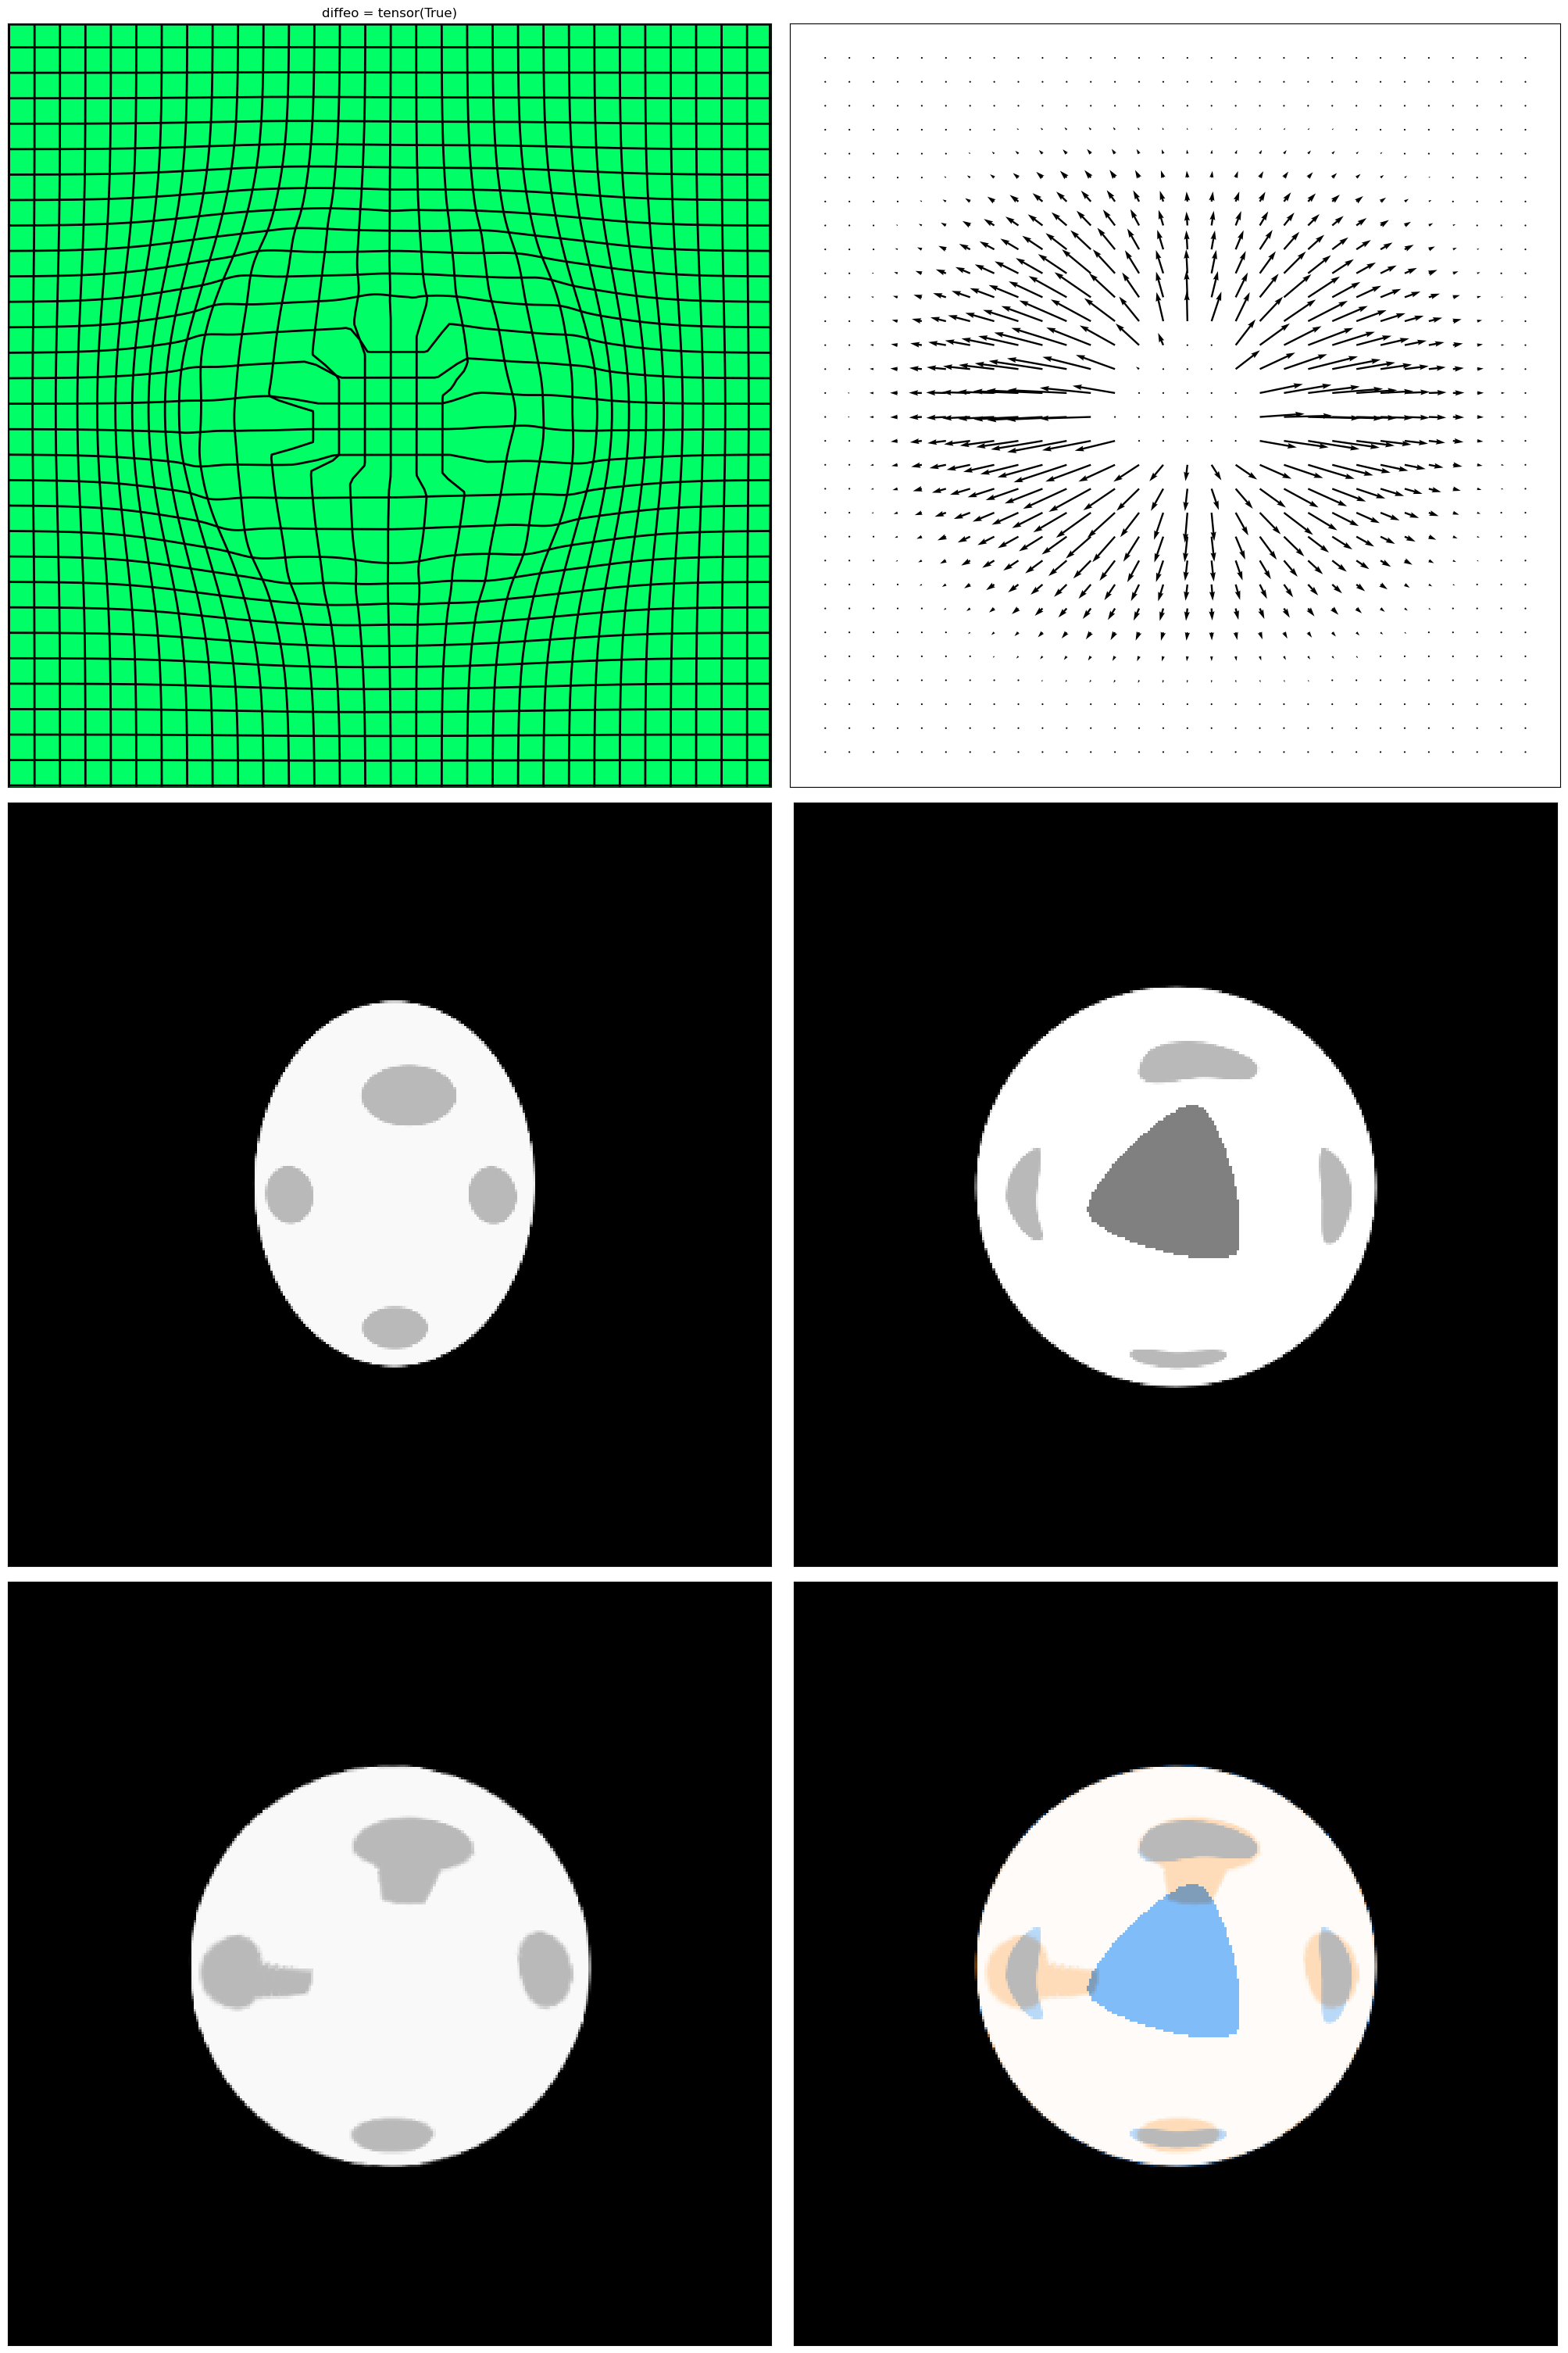

In [92]:
# mr_wm.to_device('cpu')

mr_wm.plot(False)
mr_wm.mp.plot()
mr_wm.plot_deform()
plt.show()

Annimation :
<img src="gifs/playExample_MetaMask_wb.gif" width="500" align="center">

## 2.b./ Weighted Metamoprhosis with evolutive mask

To compute the mask we simply apply a LDDMM registration to the segmentation from a small ball at its center, prior the registration. It is quick and need little parameter adjustments. Namely the variance sigma of the RKHS in order to get a mask more or less precise, and the number of integration, that that have to be the same as the main WM integration.

Progress: [##########] 100.00% Done...  , 25.2431).
 (ssd :  , 24.8982).
Computation of forward done in  0:00:11s and 0.580cents  s

Computation of lddmm done in  0:00:11s and 0.581cents  s

Computation done in  0:00:11s and 0.581cents  s


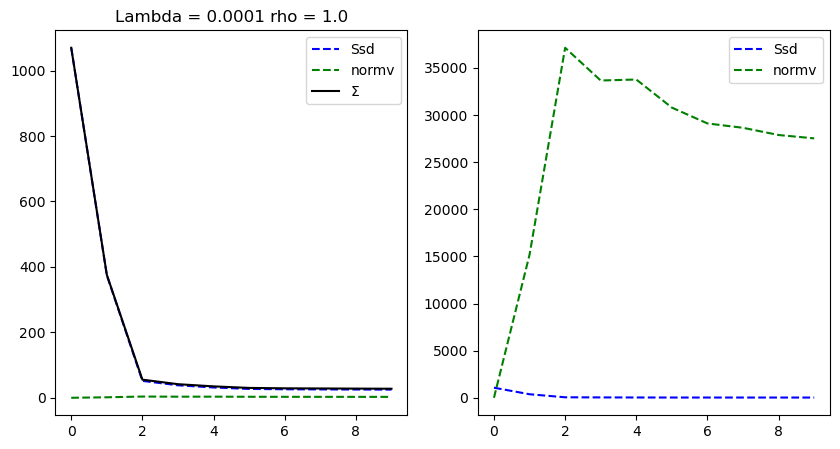

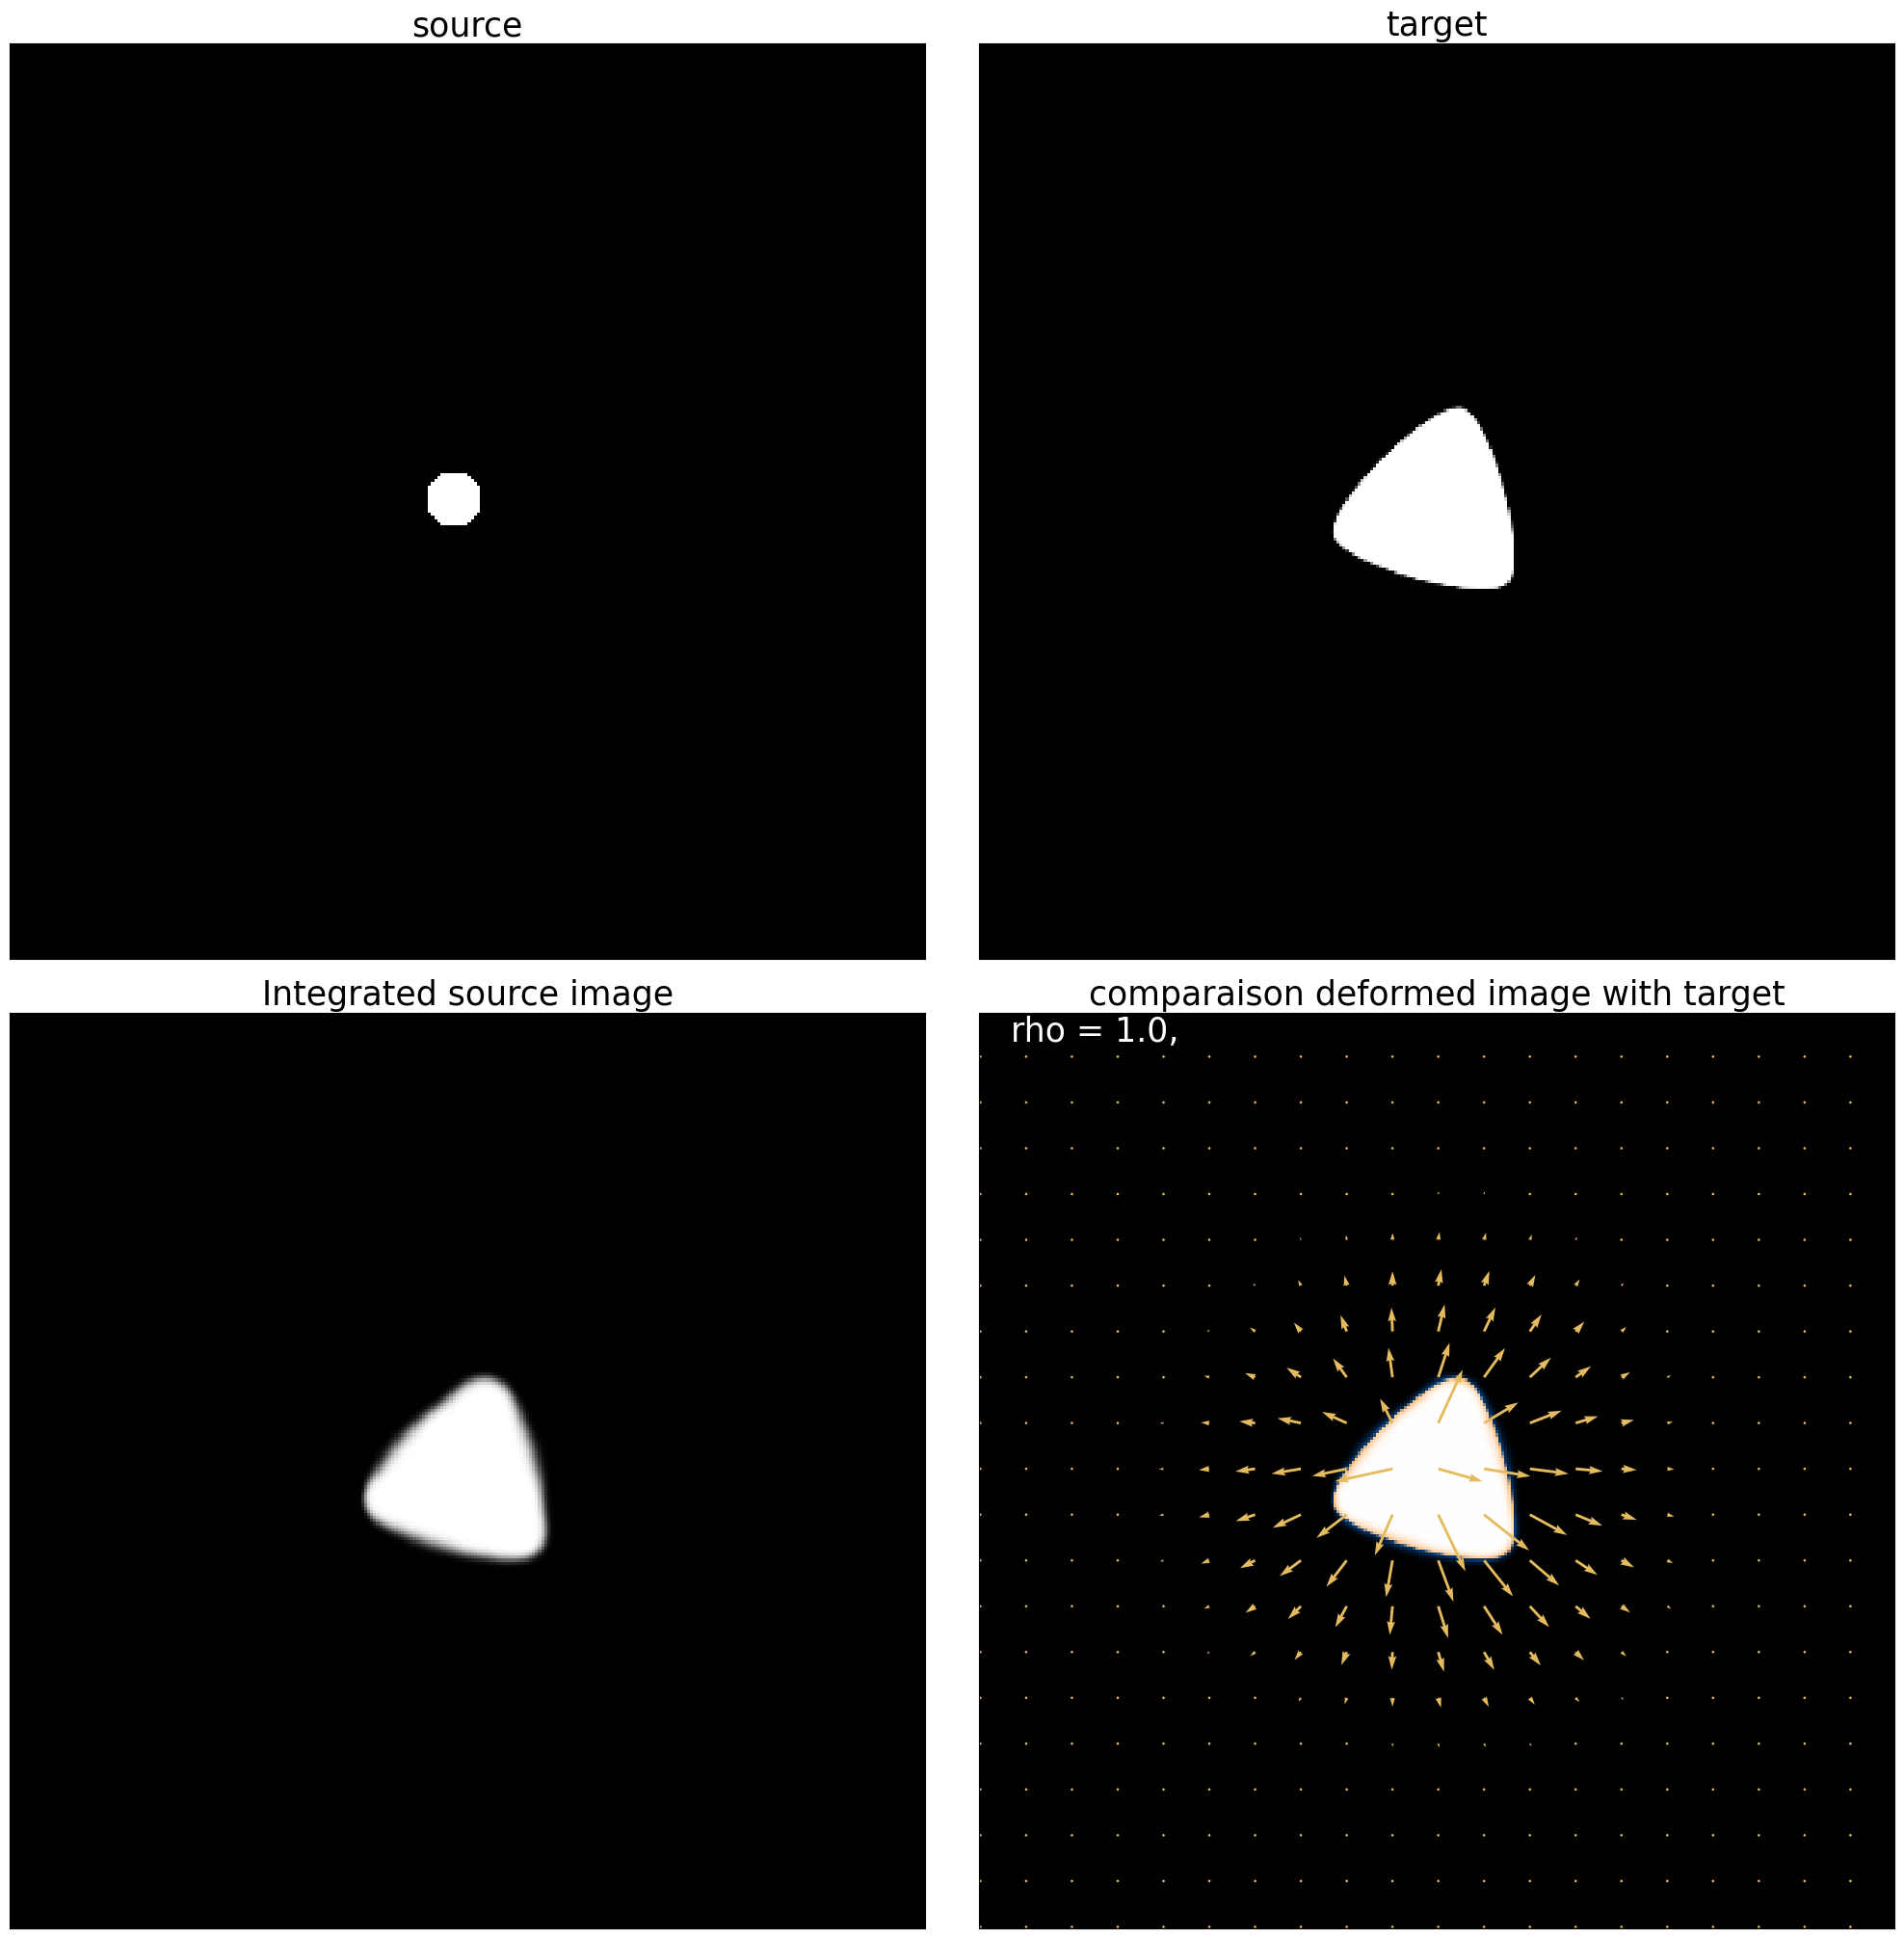

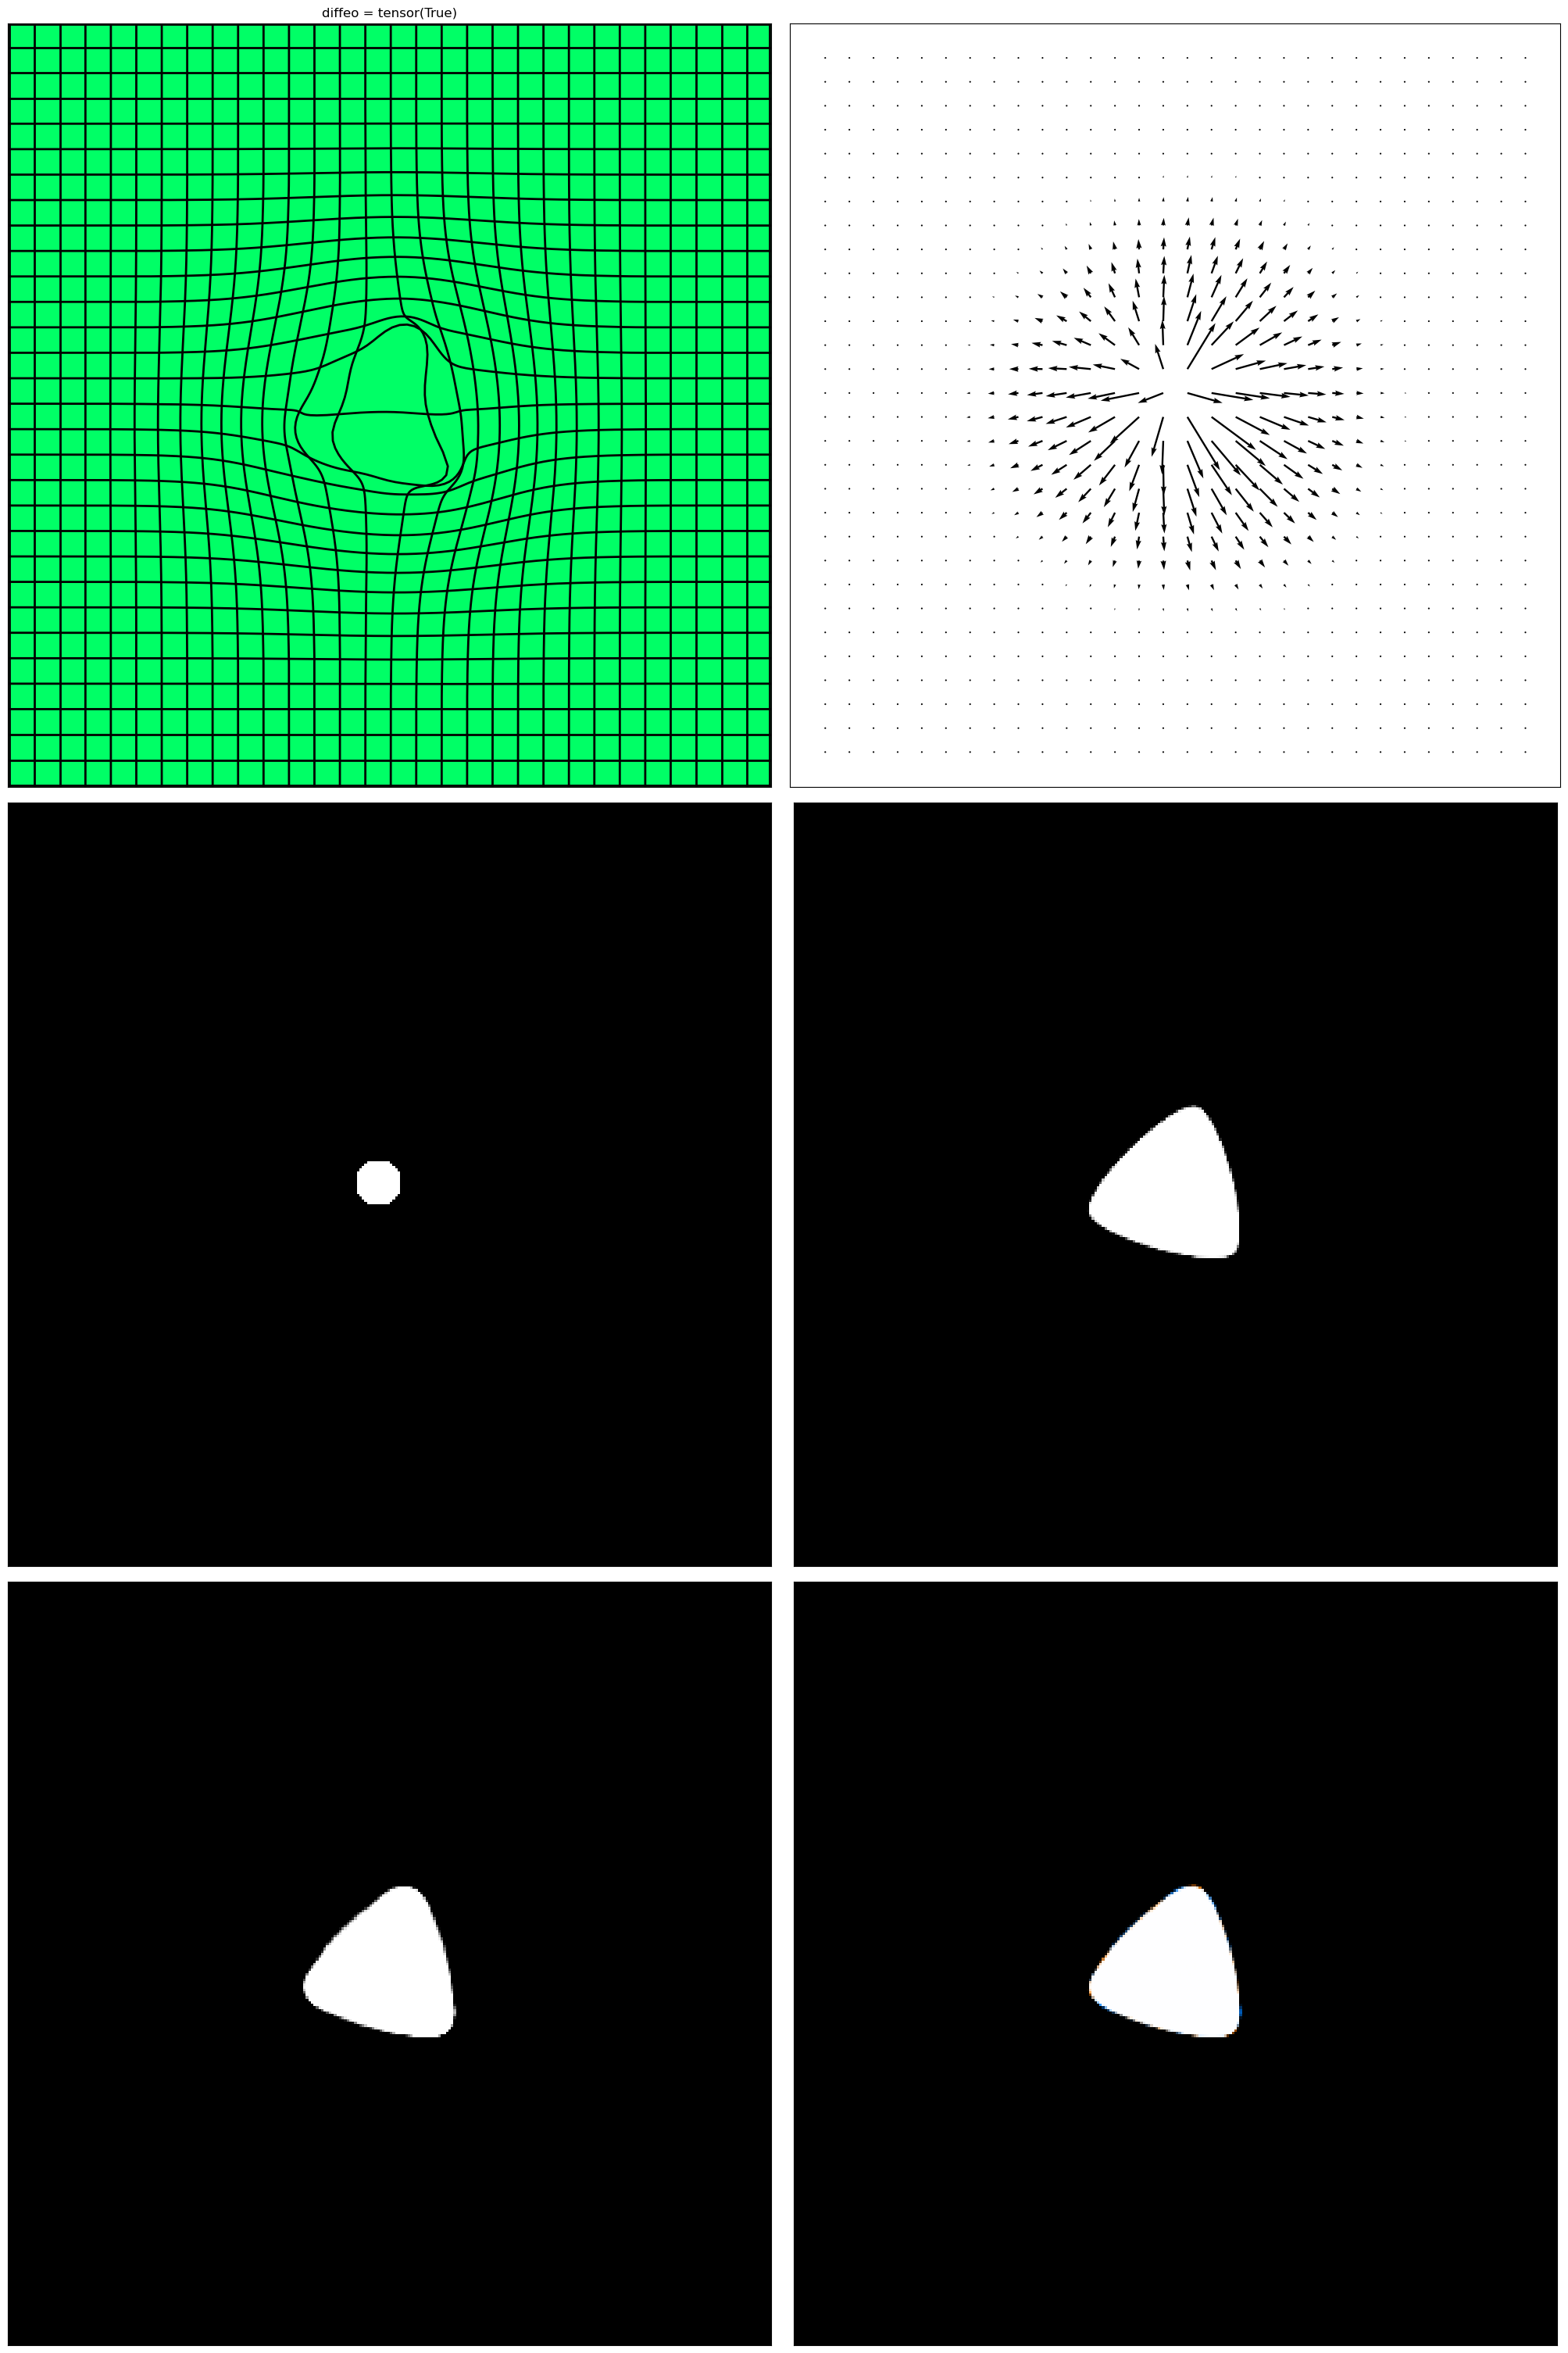

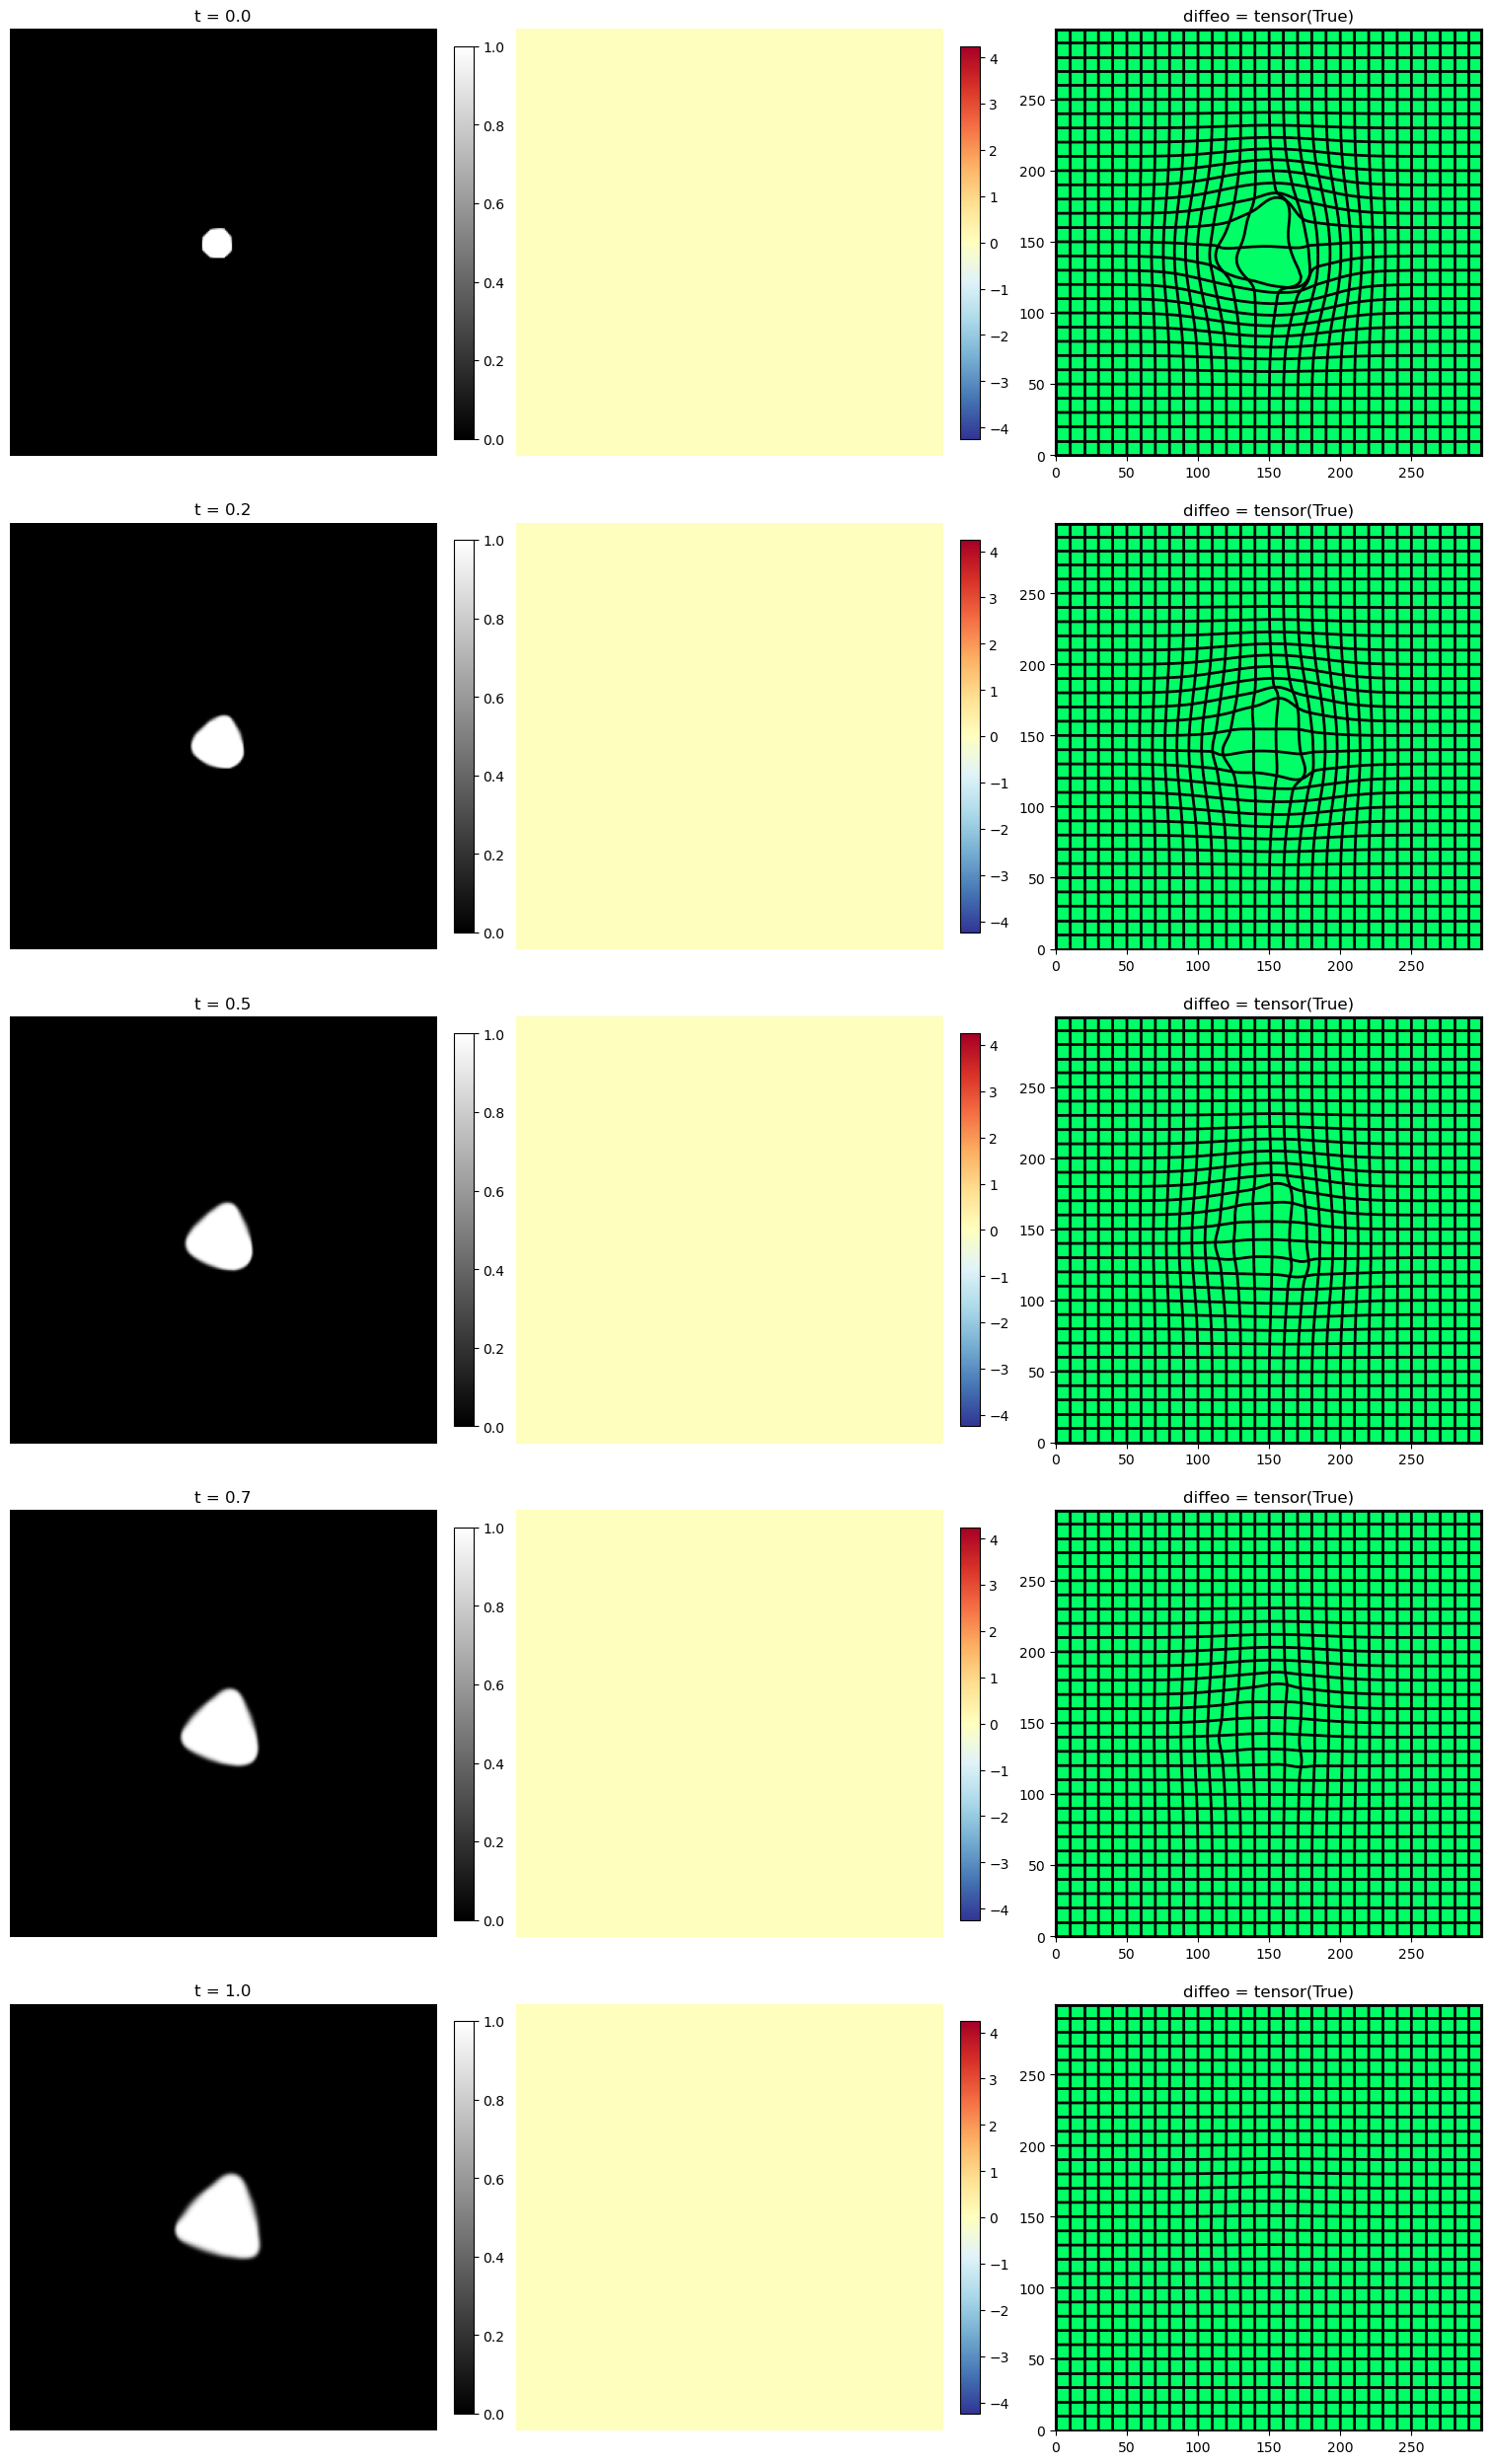

In [93]:

# sigma= [(1,1),(5,5),(10,10),(30,30)]
residuals = 0
start = time.time()
# sigma = [8,10]

mr = mt.lddmm(ini_ball,seg,residuals,kernelOp,.0001,
                    integration_steps=15,n_iter=10,grad_coef=1,
                    safe_mode=False,
                  dx_convention='pixel',
              optimizer_method='LBFGS_torch'
              )
end = time.time()
print("\nComputation done in ",format_time(end - start)," s")
mr.plot()
mr.plot_deform()
mr.mp.plot()
plt.show()
mask = mr.mp.image_stock  # Saving the succession of images.


The mask will be the successives images on the left column. 
We use the same parameters than the experiment with constant mask.

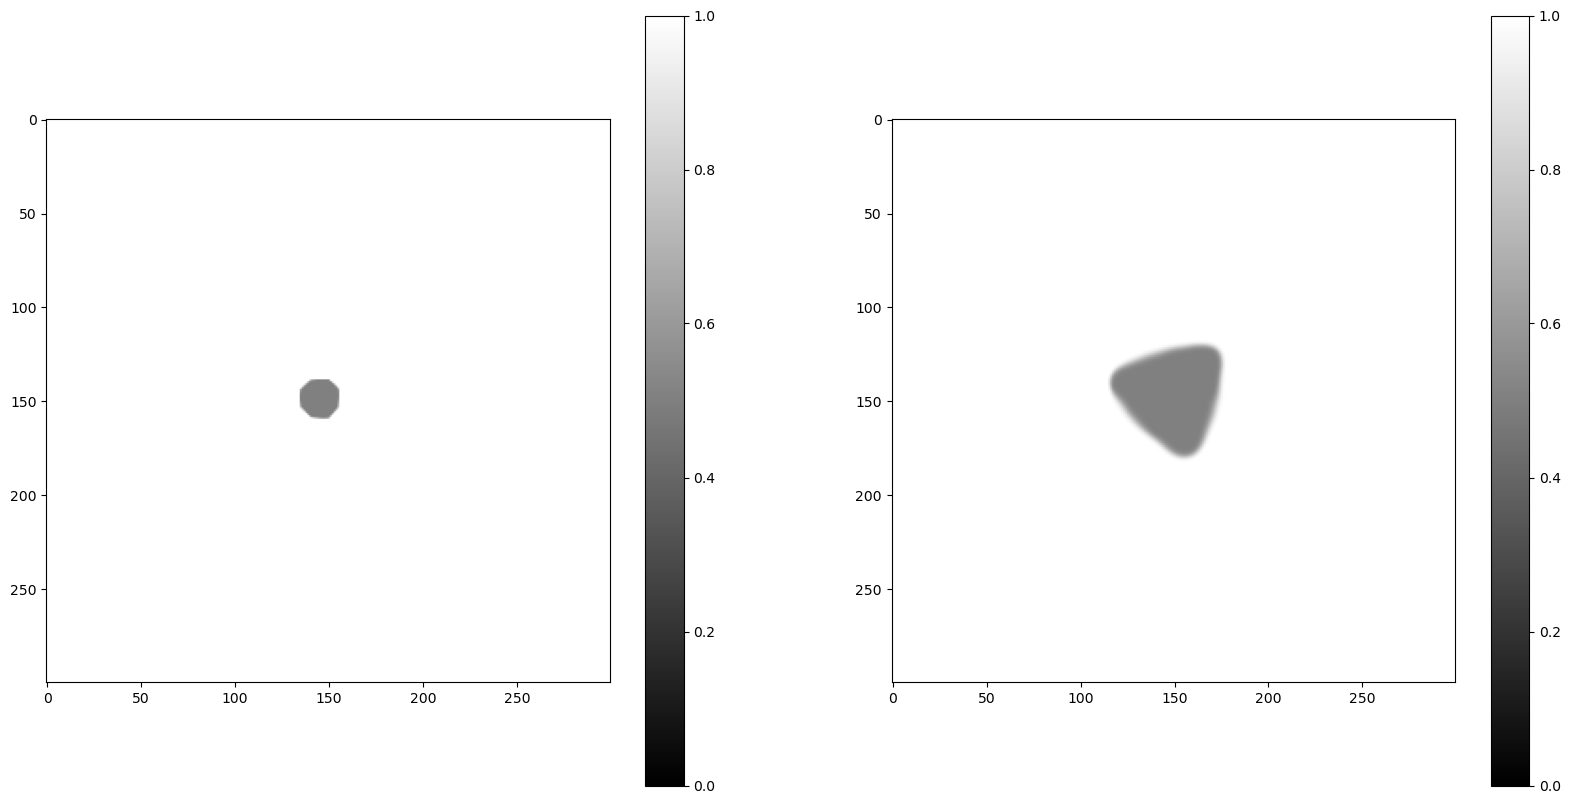

In [94]:
mask = mr.mp.image_stock  # Saving the succession of images.
# %matplotlib qt
mask = 1 - .5*mask
fig,ax =plt.subplots(1,2,figsize=(20,10))
a =ax[0].imshow(mask[0,0].cpu().numpy(),cmap='gray',vmin=0,vmax=1)
fig.colorbar(a,ax=ax[0])
b = ax[1].imshow(mask[-1,0].cpu().numpy(),cmap='gray',vmin=0,vmax=1)
fig.colorbar(b,ax=ax[1])
plt.show()

In [95]:
n_iter= 15
grad_coef = 1
residuals = 0
mask = mask.to(device)
# residuals = mr_wm.to_analyse[0].clone().to(device)
mr_wm = mt.weighted_metamorphosis(source,target,residuals,mask,
                    kernelOp,lamb,
                    n_iter,grad_coef,
                    safe_mode=False,
                    dx_convention='pixel',
                    optimizer_method='LBFGS_torch'
                    # optimizer_method='adadelta'                                  
                                  )

plop
Weighted
not oriented
Progress: [##########] 100.00% Done...  , 56.5248).
 (ssd :  , 54.3916).
Computation of forward done in  0:00:20s and 0.673cents  s

Computation of weighted_metamorphosis done in  0:00:20s and 0.674cents  s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1430977582931519].


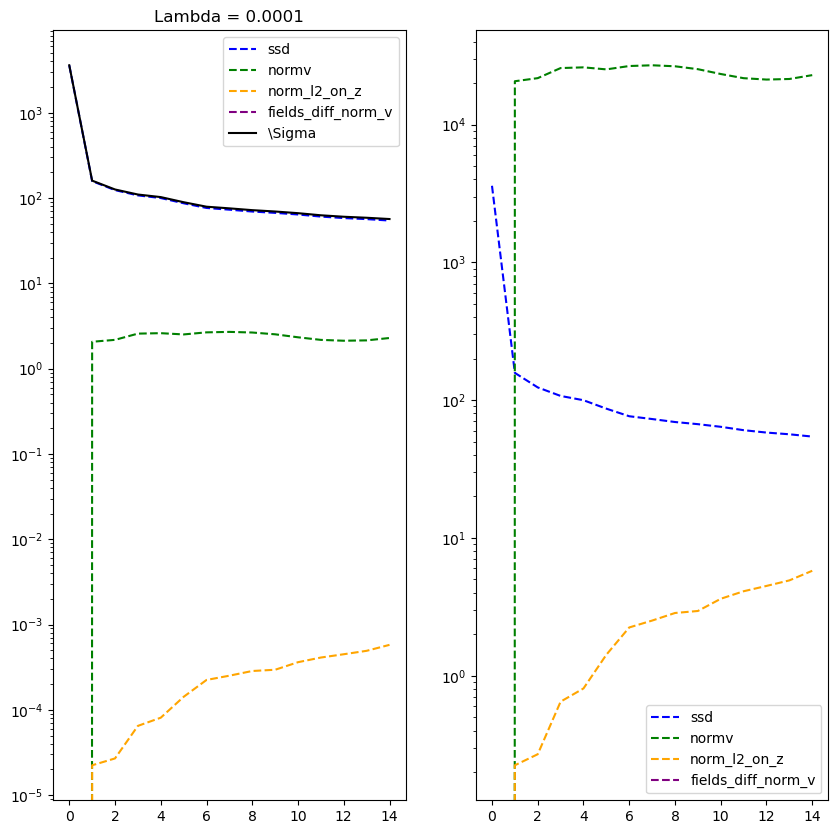

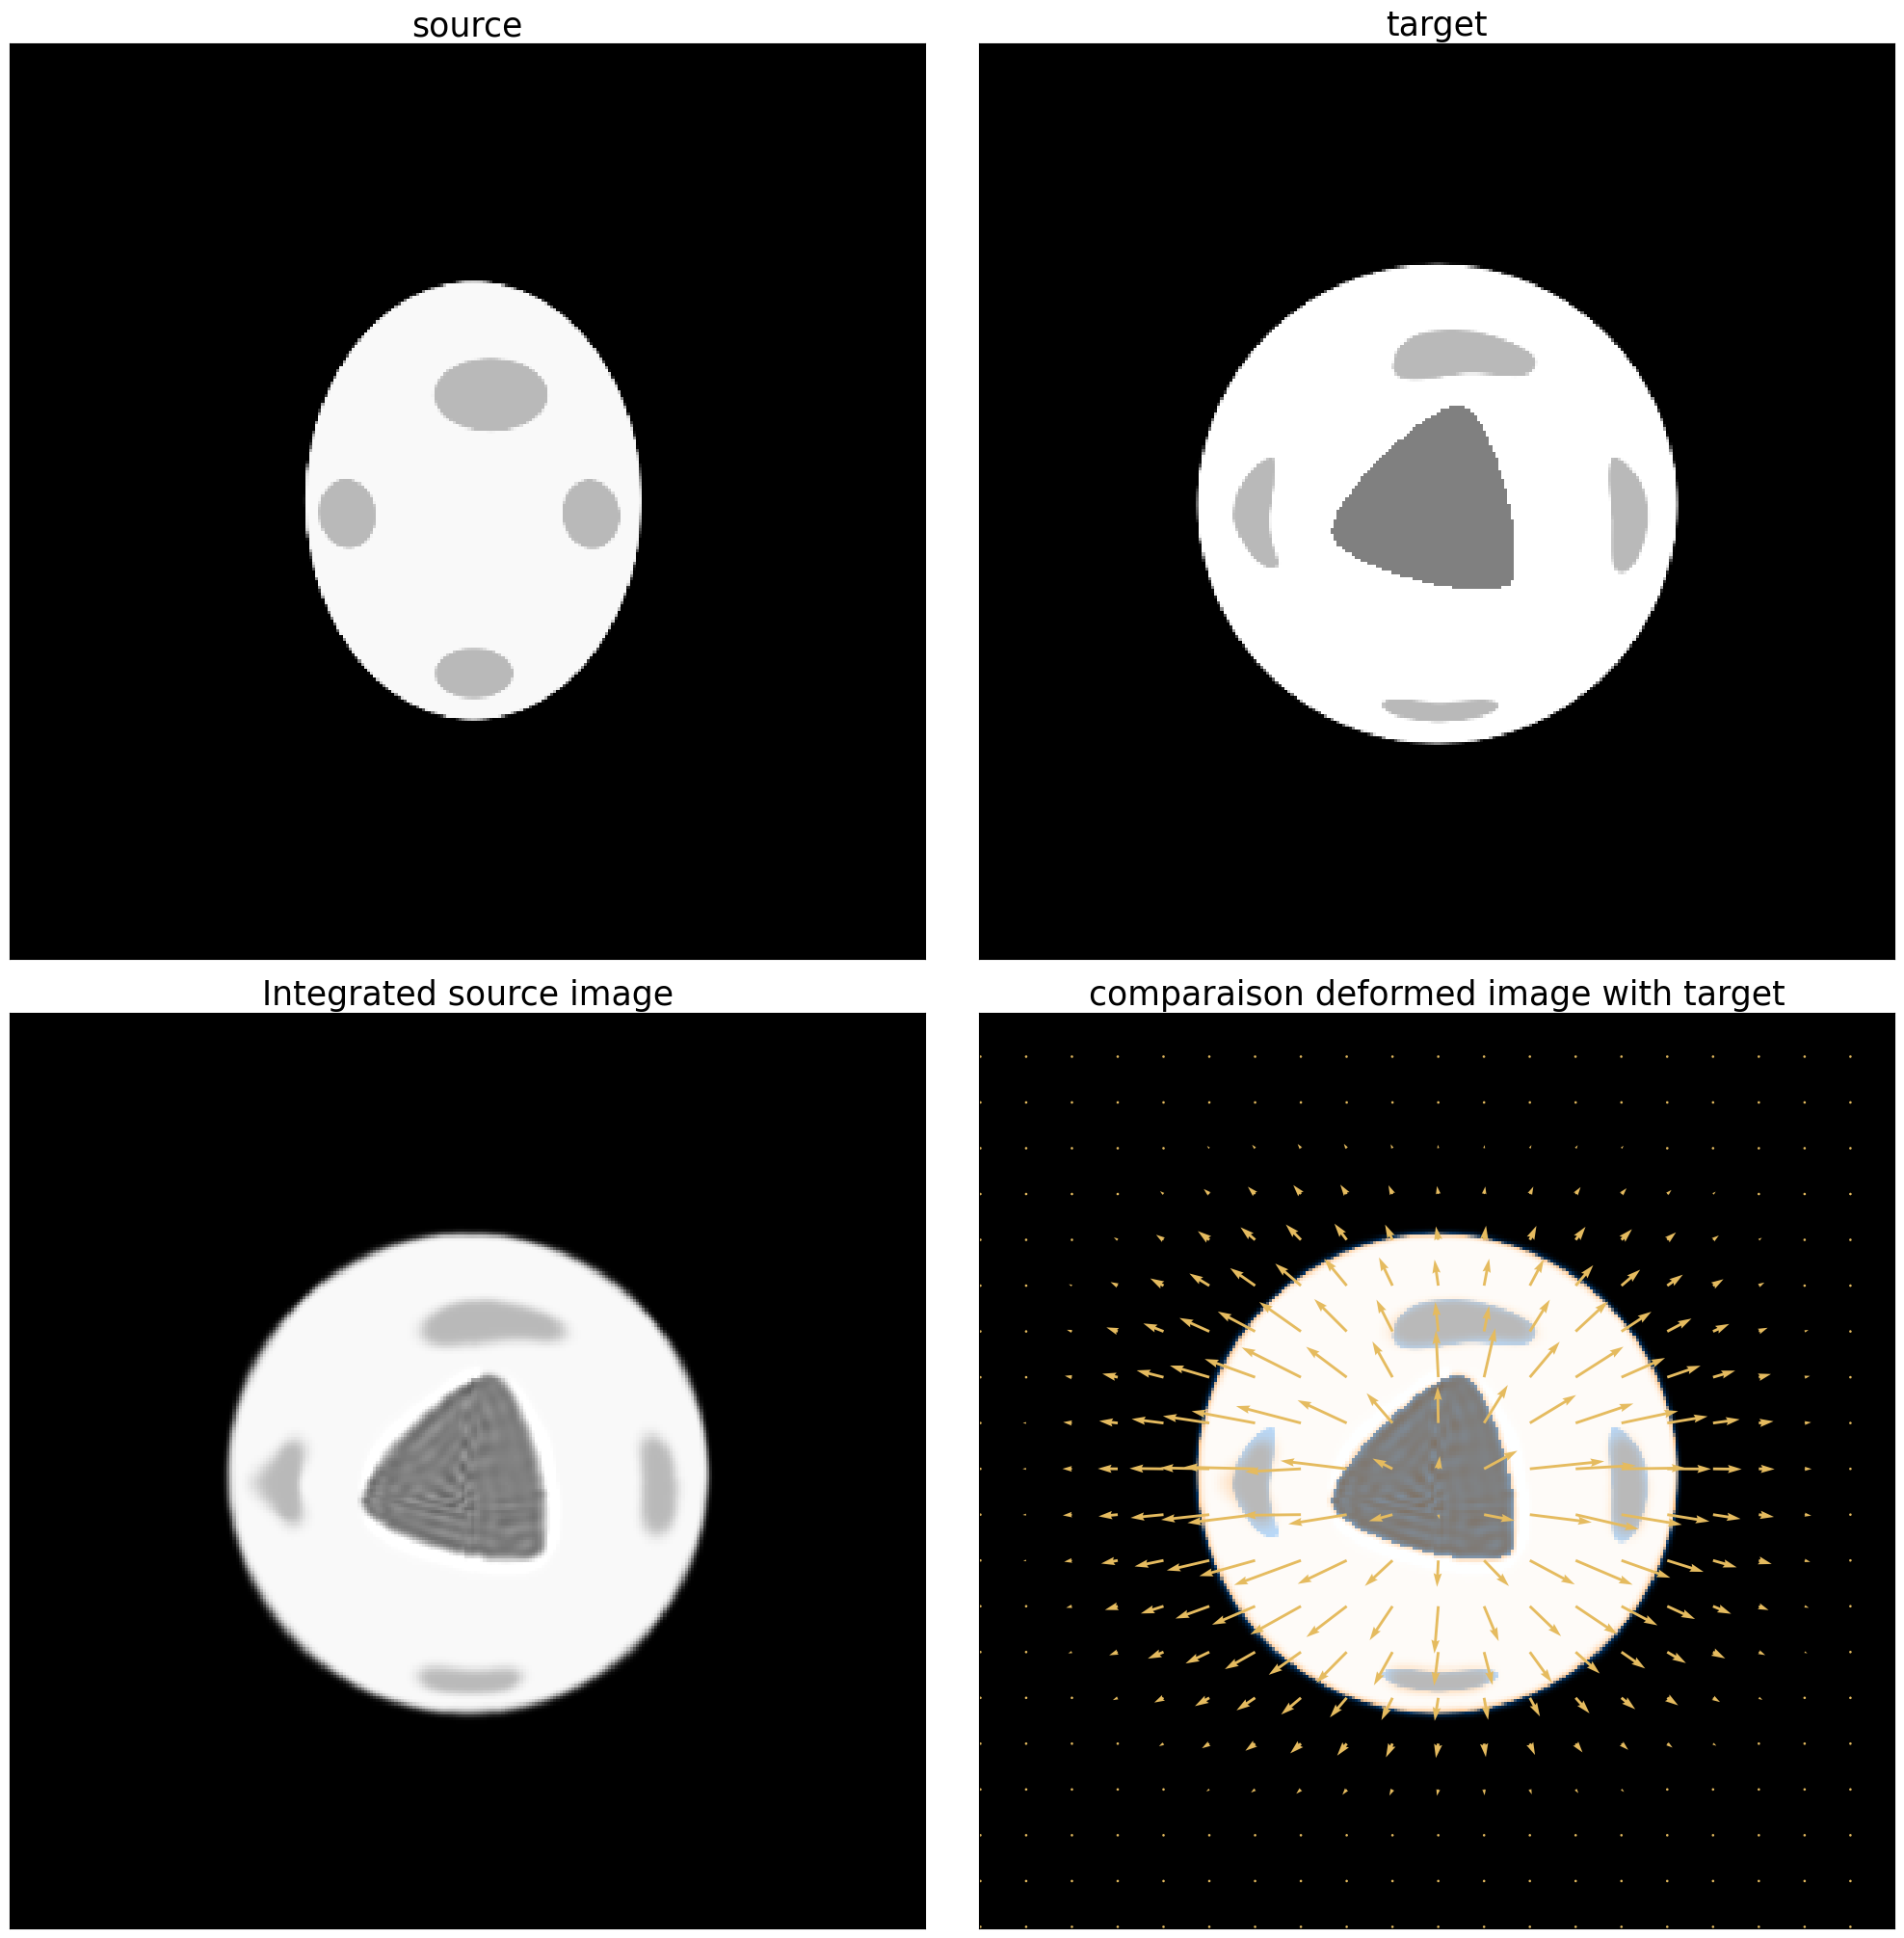

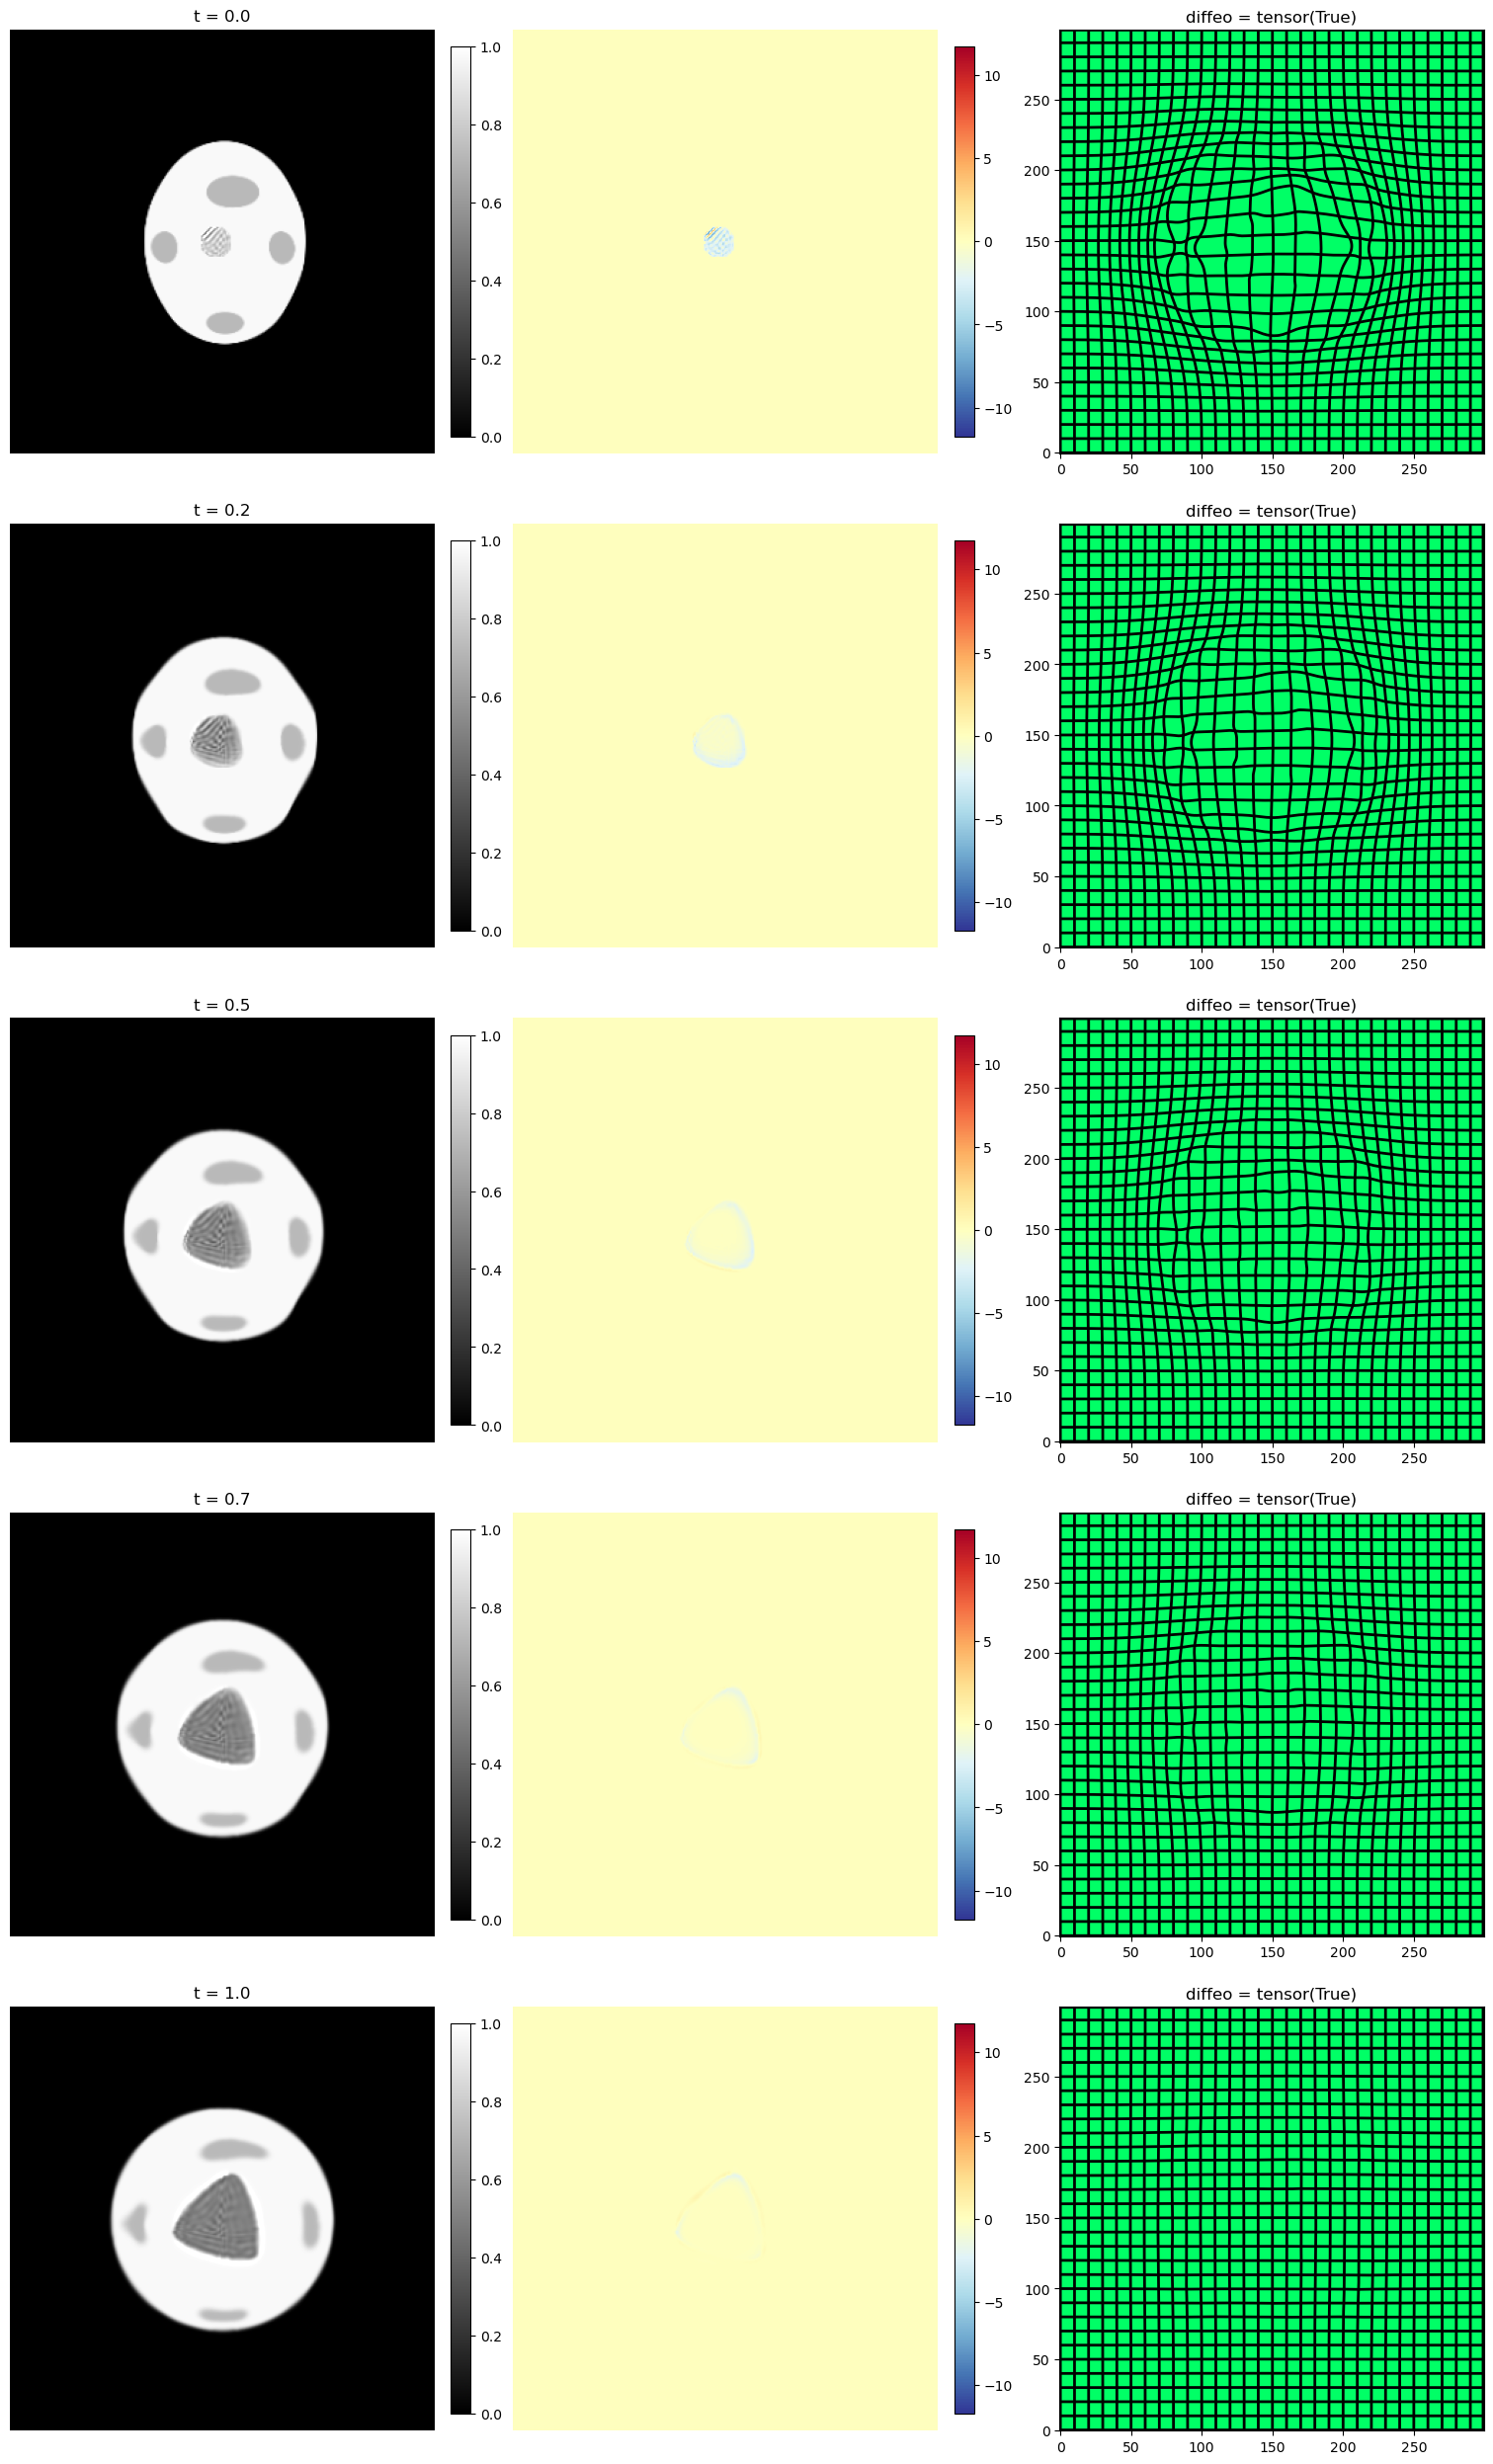

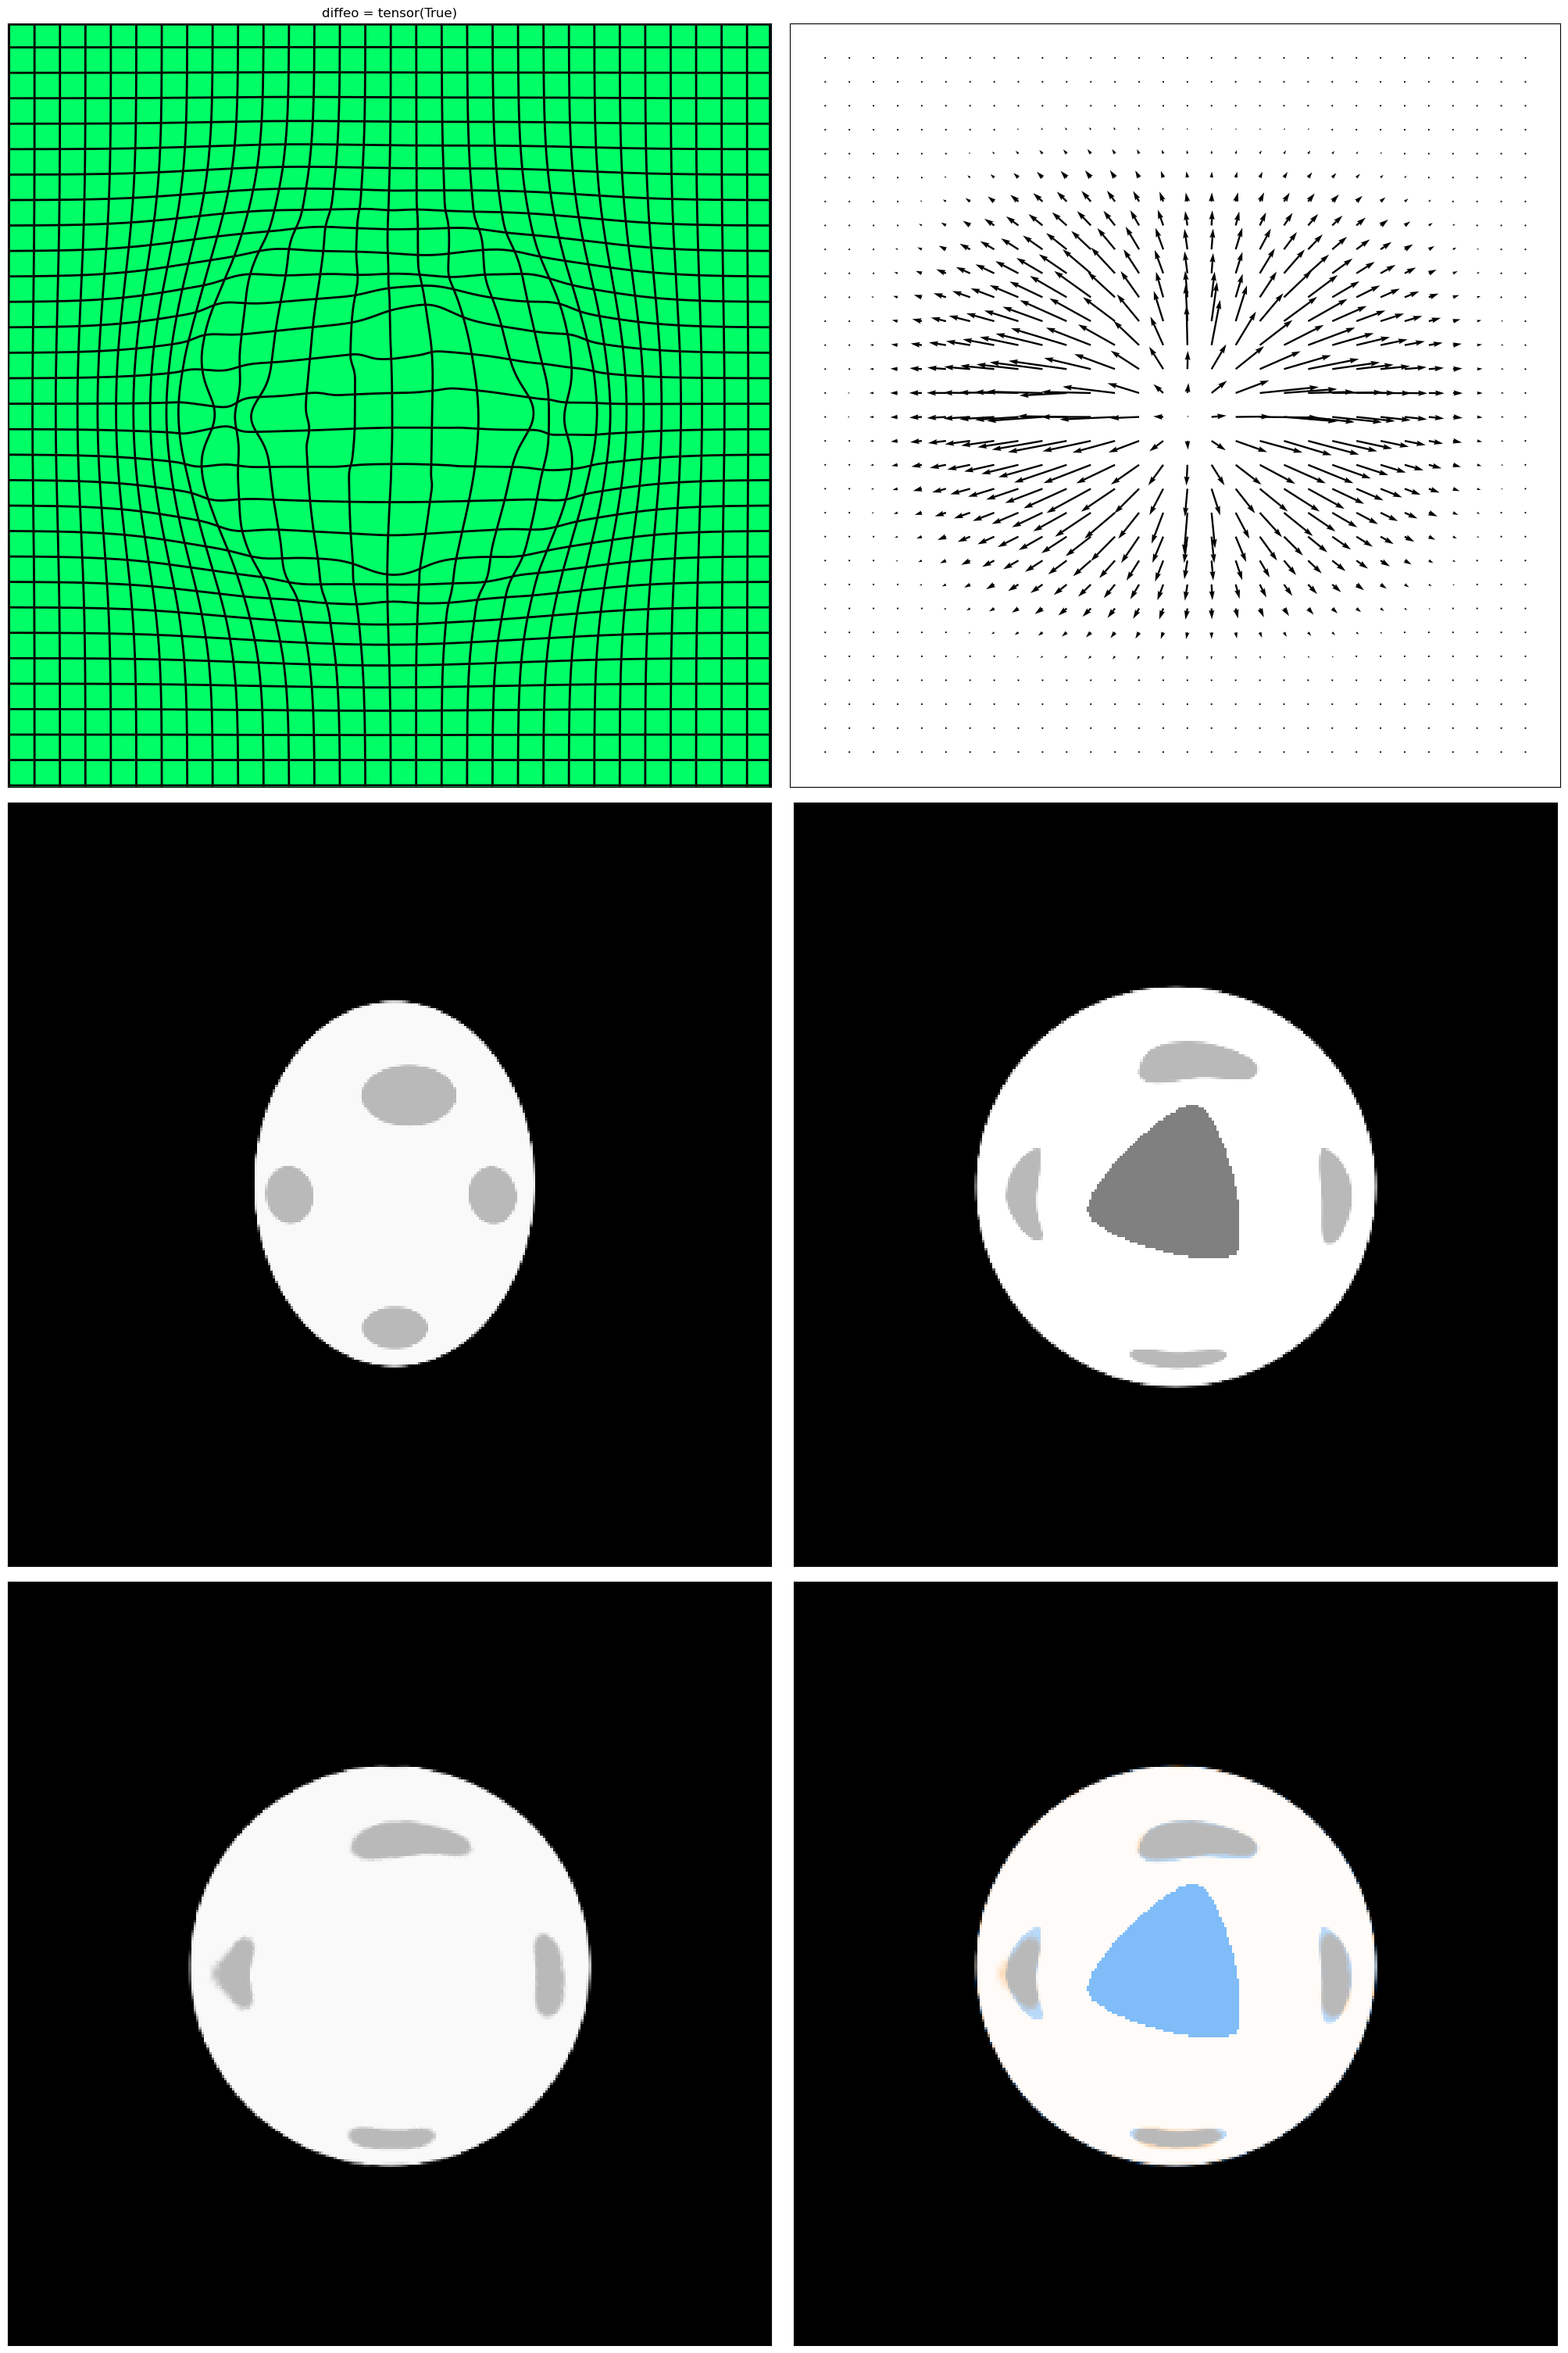

In [96]:
mr_wm.plot(True)
mr_wm.mp.plot()
mr_wm.plot_deform()
plt.show()

Annimation :
<img src="gifs/playExample_MetaMask.gif" width="500" align="center">